In [1]:
import numpy as np
from scipy import fft, optimize
import NAFFlib as naf
import statistics as st
import matplotlib.pyplot as plt
import time
from IPython.display import display, Math
import re
import csv

#Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
np.set_printoptions(suppress=True)

# BPM Data

In [2]:
#Get data from all BPMs from sdds file
Name_xbpms = []
Name_ybpms = []
Pos_xbpms = np.zeros([1024, 168])
Pos_ybpms = np.zeros([1024, 167])
S_xbpms = np.zeros([1024, 168])
S_ybpms = np.zeros([1024, 167])
with open('data_Wed_Jun_28_20-13-14_2023') as output:
    Lines = output.readlines()
    index_ix = index_jx = 0
    index_iy = index_jy = 0
    init_i = 414
    for i, line in enumerate(Lines[1:]):
        Line = []
        #xBPM Names
        if i >= 67 and i < 95:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_xbpms.append(Line[:-1])
        
        #yBPM Names
        if i >= 241 and i < 269:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_ybpms.append(Line[:-1])
           
        #s and positions for xBPM
        if i > init_i:
            row = re.split("\s+", line)
            S_xbpms[index_ix][index_jx] = float(row[1])
            Pos_xbpms[index_ix][index_jx] = float(row[2])
            index_jx = (i - init_i)%168
            
            if (i - init_i)%168 == 0 and (i - init_i) != 0:
                index_ix += 1
        
        #s and positions for yBPM
        if i > init_i and i < 171423:
            row = re.split("\s+", line)
            S_ybpms[index_iy][index_jy] = float(row[6])
            Pos_ybpms[index_iy][index_jy] = float(row[7])
            index_jy = (i - init_i)%167
            
            if (i - init_i)%167 == 0 and (i - init_i) != 0:
                index_iy += 1
        
Name_xbpms = [item for row in Name_xbpms for item in row]
Name_ybpms = [item for row in Name_ybpms for item in row]

In [3]:
# Positions
init_turn = 0 # Starting turn
BPMx = Pos_xbpms.T[:, init_turn:] #np.loadtxt('BPMx.csv', delimiter=',')[:, init_turn:]
BPMy = Pos_ybpms.T[:, init_turn:] #np.loadtxt('BPMy.csv', delimiter=',')[:, init_turn:]

N_BPMx, N_turns = np.shape(BPMx) #(168, 1024-init_turn)
N_BPMy, _ = np.shape(BPMy) #(167, 1024-init_turn)

#Tunes
Nu_x_meas, Nu_y_meas = 28.235001748, 29.2290029334
nu_x_meas, nu_y_meas = Nu_x_meas%1, Nu_y_meas%1

x = np.linspace(init_turn, N_turns, N_turns)
Omega = np.linspace(0, N_turns//2, N_turns//2)/N_turns

Standard deviation of First Horizontal BPM = 0.08086005371776343


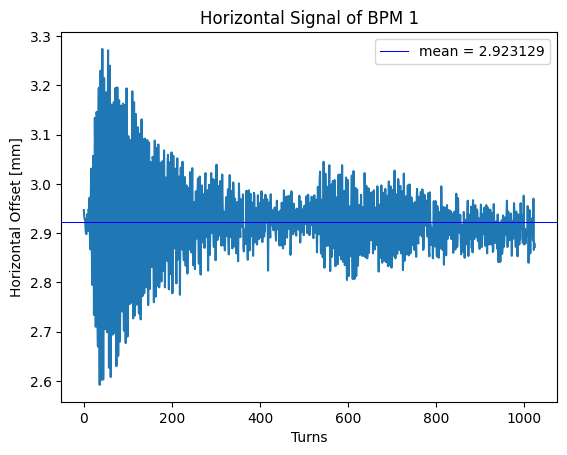

Standard deviation of First Vertical BPM = 0.14039846131415454


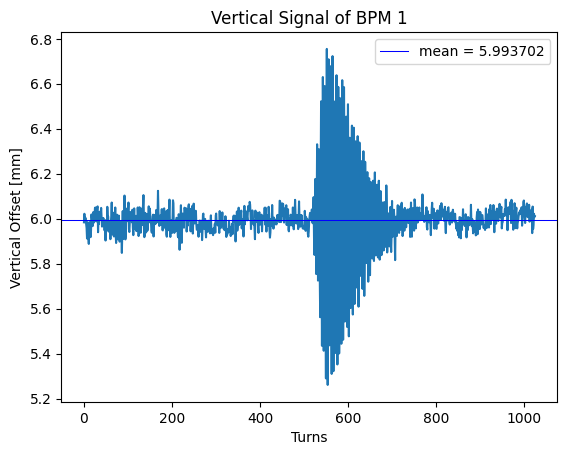

In [4]:
# Look at first BPM Signals
BPMx0 = BPMx[0]

BPMx0_mean = np.mean(BPMx0)
BPMx0_std = np.std(BPMx0)
print("Standard deviation of First Horizontal BPM =", BPMx0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMx0)
plt.axhline(y = BPMx0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMx0_mean)
plt.xlabel("Turns")
plt.ylabel("Horizontal Offset [mm]")
plt.title("Horizontal Signal of BPM 1")
plt.legend()
plt.show()

BPMy0 = BPMy[0]

BPMy0_mean = np.mean(BPMy0)
BPMy0_std = np.std(BPMy0)
print("Standard deviation of First Vertical BPM =", BPMy0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMy0)
plt.axhline(y = BPMy0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMy0_mean)
plt.xlabel("Turns")
plt.ylabel("Vertical Offset [mm]")
plt.title("Vertical Signal of BPM 1")
plt.legend()
plt.show()

0.23483365949119372


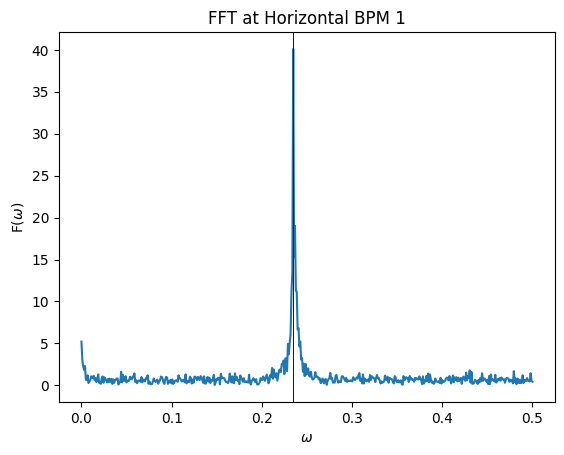

0.22896281800391388


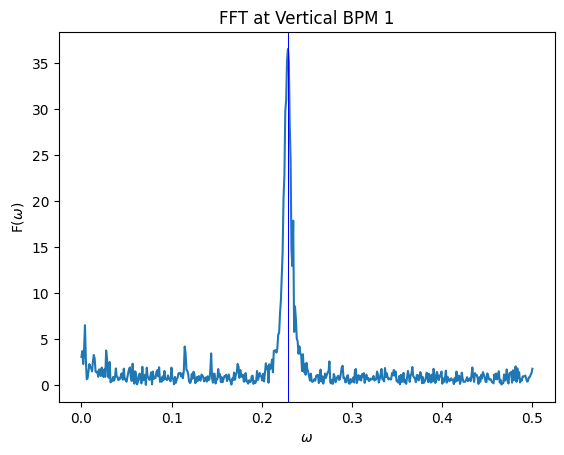

In [5]:
# Look at First BPM FFTs
BPMX0 = np.abs(fft.rfft(BPMx0)[1:])
BPMx0_Tune_scipy = Omega[np.argmax(BPMX0)]
print(BPMx0_Tune_scipy)
plt.plot(Omega, BPMX0)
plt.axvline(x = BPMx0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%BPMx0_Tune_scipy)
plt.title("FFT at Horizontal BPM 1")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()

BPMY0 = np.abs(fft.rfft(BPMy0)[1:])
BPMy0_Tune_scipy = Omega[np.argmax(BPMY0)]
print(BPMy0_Tune_scipy)
plt.plot(Omega, BPMY0)
plt.axvline(x = BPMy0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%BPMy0_Tune_scipy)
plt.title("FFT at Vertical BPM 1")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.show()

0.00016808850880467574 0.0010185889772997558


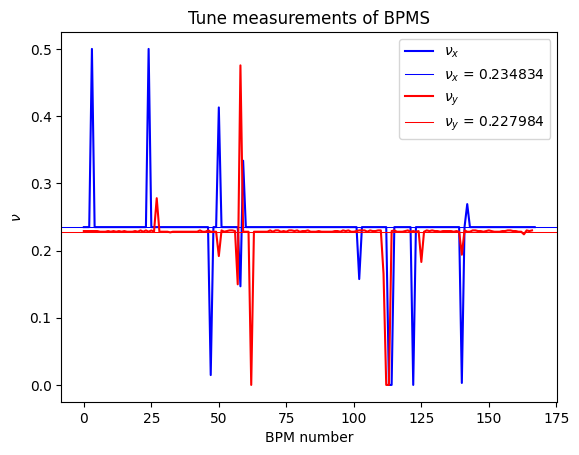

In [6]:
# Look at all FFTs to figure out Tune of machine
BPMx_Tune_Map = np.zeros(N_BPMx)
for i in range(N_BPMx):
    BPMX = np.abs(fft.rfft(BPMx[i])[1:]) 
    BPMx_Tune_Map[i] = Omega[np.argmax(BPMX)]
    # BPM 113 had a flat line

BPMy_Tune_Map = np.zeros(N_BPMy)
for i in range(N_BPMy):
    BPMY = np.abs(fft.rfft(BPMy[i])[1:])
    BPMy_Tune_Map[i] = Omega[np.argmax(BPMY)]

nu_x, nu_y = st.mode(BPMx_Tune_Map), st.mode(BPMy_Tune_Map)
#Difference from experiment
delta_nu_x, delta_nu_y = abs(nu_x_meas - nu_x), abs(nu_y_meas - nu_y)
print(delta_nu_x, delta_nu_y)

plt.plot(BPMx_Tune_Map, color = 'b', label = r"$\nu_x$")
plt.axhline(y = nu_x, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%nu_x)
plt.plot(BPMy_Tune_Map, color = 'r', label = r"$\nu_y$")
plt.axhline(y = nu_y, color = 'r', linestyle = '-', linewidth = .75, label = r"$\nu_y$ = %f"%nu_y)
plt.xlabel("BPM number")
plt.ylabel(r"$\nu$")
plt.title("Tune measurements of BPMS")
plt.legend()
plt.show()

In [7]:
# Collect bad BPMs
def Bad_Bpms(Tune_Map, nu, N_BPM):
    Tune_Offset = np.abs(Tune_Map - np.ones(N_BPM)*nu)
    Bad_BPM = []
    for i, offset in enumerate(Tune_Offset):
        if offset > .01:
            Bad_BPM.append(i)
    return Bad_BPM
print(Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx))
print(Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy))

[3, 24, 47, 50, 58, 59, 102, 113, 114, 122, 140, 142]
[27, 50, 57, 58, 62, 111, 112, 113, 125, 140]


## Phase Transfer Matrix Calculation

In [8]:
print(Name_ybpms[50:])
print(S_ybpms[0, 50:])

['bi9-b7.1', 'bi9-b7', 'bi9-bv6', 'bi9-b4', 'bi9-b3', 'bi9-b1', 'g9-bx', 'g9-bx.2', 'g9-bx.1', 'g10-bx', 'bo10-b1', 'bo10-b3', 'bo10-b3.1', 'bo10-b4', 'bo10-bv5', 'bo10-b7', 'bo10-b8', 'bo10-bv9', 'bo10-bv11', 'bo10-bv13', 'bo10-bv15', 'bo10-bv17', 'bo10-bv19', 'bo11-bv21', 'bo11-bv19', 'bo11-bv17', 'bo11-bv15', 'bo11-bv13', 'bo11-bv11', 'bo11-bv9', 'bo11-b8', 'bo11-b7', 'bo11-bv5', 'bo11-b4', 'bo11-b3', 'bo11-b1', 'g11-bx', 'g12-bx', 'bi12-b1', 'bi12-b3', 'bi12-b4', 'bi12-bv6', 'bi12-b7', 'bi12-b8', 'bi12-bv10', 'bi12-bv12', 'bi12-bv14', 'bi12-bv16', 'bi12-bv18', 'bi12-bv20', 'bi1-bv20', 'bi1-bv18', 'bi1-bv16', 'bi1-bv14', 'bi1-bv12', 'bi1-bv10', 'bi1-b8', 'bi1-b7', 'bi1-bv6', 'bi1-b4', 'bi1-b3', 'bi1-b1', 'g1-bx', 'g2-bx', 'bo2-b1', 'bo2-b3', 'bo2-b4', 'bo2-bv5', 'bo2-b7', 'bo2-b8', 'bo2-bv9', 'bo2-bv11', 'bo2-bv13', 'bo2-bv15', 'bo2-bv17', 'bo2-bv19', 'bo3-bv21', 'bo3-bv19', 'bo3-bv17', 'bo3-bv15', 'bo3-bv13', 'bo3-bv11', 'bo3-bv9', 'bo3-b8', 'bo3-b7.1', 'bo3-b7', 'bo3-bv5', 'bo3-b4

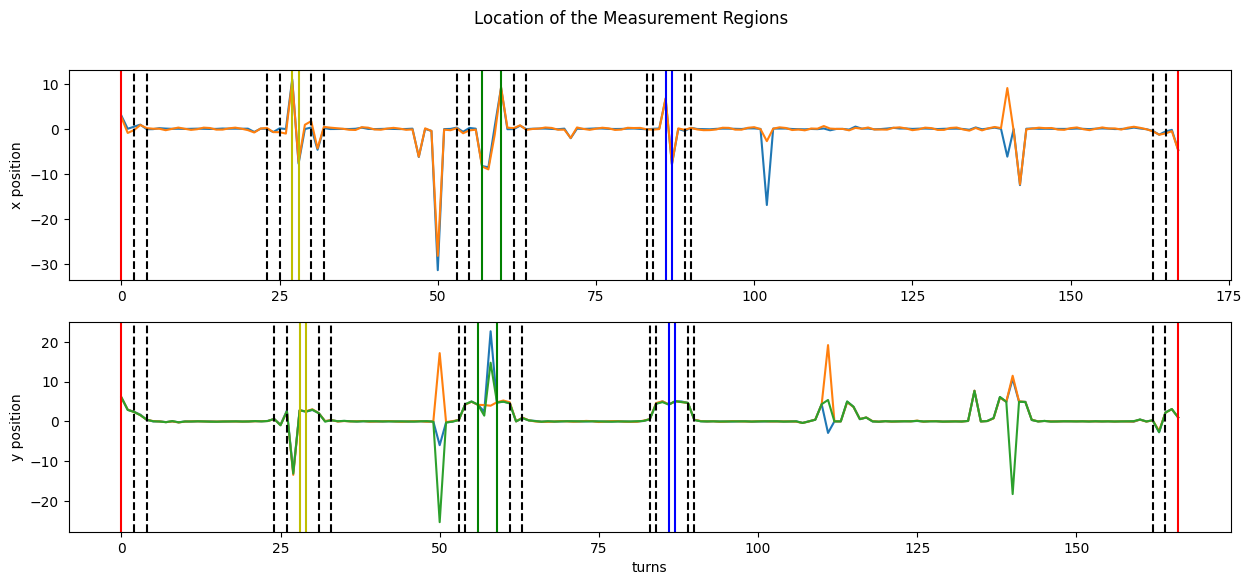

In [9]:
fig, Ax = plt.subplots(2, 1, figsize = (15, 6))
Ax[0].plot(Pos_xbpms[0, :])
Ax[0].plot(Pos_xbpms[36, :])
fig.suptitle("Location of the Measurement Regions")

#IP6
Ax[0].axvline(x = 163, color = 'k', ls = '--')
Ax[0].axvline(x = 165, color = 'k', ls = '--')

Ax[0].axvline(x = 167, color = 'r')
Ax[0].axvline(x = 0, color = 'r')

Ax[0].axvline(x = 2, color = 'k', ls = '--')
Ax[0].axvline(x = 4, color = 'k', ls = '--')

#IP8
Ax[0].axvline(x = 23, color = 'k', ls = '--')
Ax[0].axvline(x = 25, color = 'k', ls = '--')

Ax[0].axvline(x = 27, color = 'y')
Ax[0].axvline(x = 28, color = 'y')

Ax[0].axvline(x = 30, color = 'k', ls = '--')
Ax[0].axvline(x = 32, color = 'k', ls = '--')

#IP10
Ax[0].axvline(x = 53, color = 'k', ls = '--')
Ax[0].axvline(x = 55, color = 'k', ls = '--')

Ax[0].axvline(x = 57, color = 'g')
Ax[0].axvline(x = 60, color = 'g')

Ax[0].axvline(x = 62, color = 'k', ls = '--')
Ax[0].axvline(x = 64, color = 'k', ls = '--')

#IP12
Ax[0].axvline(x = 83, color = 'k', ls = '--')
Ax[0].axvline(x = 84, color = 'k', ls = '--')

Ax[0].axvline(x = 86, color = 'b')
Ax[0].axvline(x = 87, color = 'b')

Ax[0].axvline(x = 89, color = 'k', ls = '--')
Ax[0].axvline(x = 90, color = 'k', ls = '--')

Ax[1].plot(Pos_ybpms[35, :])
Ax[1].plot(Pos_ybpms[36, :])
Ax[1].plot(Pos_ybpms[39, :])

#IP6
Ax[1].axvline(x = 162, color = 'k', ls = '--')
Ax[1].axvline(x = 164, color = 'k', ls = '--')

Ax[1].axvline(x = 0, color = 'r')
Ax[1].axvline(x = 166, color = 'r')

Ax[1].axvline(x = 2, color = 'k', ls = '--')
Ax[1].axvline(x = 4, color = 'k', ls = '--')

#IP8
Ax[1].axvline(x = 24, color = 'k', ls = '--')
Ax[1].axvline(x = 26, color = 'k', ls = '--')

Ax[1].axvline(x = 28, color = 'y')
Ax[1].axvline(x = 29, color = 'y')

Ax[1].axvline(x = 31, color = 'k', ls = '--')
Ax[1].axvline(x = 33, color = 'k', ls = '--')

#IP10
Ax[1].axvline(x = 53, color = 'k', ls = '--')
Ax[1].axvline(x = 54, color = 'k', ls = '--')

Ax[1].axvline(x = 56, color = 'g')
Ax[1].axvline(x = 59, color = 'g')

Ax[1].axvline(x = 61, color = 'k', ls = '--')
Ax[1].axvline(x = 63, color = 'k', ls = '--')

#IP12
Ax[1].axvline(x = 83, color = 'k', ls = '--')
Ax[1].axvline(x = 84, color = 'k', ls = '--')

Ax[1].axvline(x = 86, color = 'b')
Ax[1].axvline(x = 87, color = 'b')

Ax[1].axvline(x = 89, color = 'k', ls = '--')
Ax[1].axvline(x = 90, color = 'k', ls = '--')

Ax[0].set_ylabel("x position")
Ax[1].set_xlabel("turns")
Ax[1].set_ylabel("y position")

plt.show()

## Linear Regression Calculation

In [10]:
def Mat_param4D(result):
    M = result.coef_
    print("M:")
    print(M)
    
    det = np.linalg.det(M)
    print("determinant:", det)
    M /= np.sqrt(np.sqrt(det))
    print("determinant after normalization:", np.linalg.det(M))
    print("M after normalization:")
    print(M)

    #Symplecticity check
    # [S2, 0]
    # [0, S2]
    S = np.matrix([[0, 1, 0, 0],
                   [-1, 0, 0, 0],
                   [0, 0, 0, 1],
                   [0, 0, -1, 0]])

#     print("Symplecticity:")
    Sres = M @ S @ M.T
    print(Sres)
    print("Symplecticity Error:", mean_squared_error(np.asarray(Sres), np.asarray(S), squared = False))

    # Edward-Teng Parameterization
    A = np.matrix([M[0, :2], M[1, :2]])
    B = np.matrix([M[0, 2:], M[1, 2:]])
    C = np.matrix([M[2, :2], M[3, :2]])
    D = np.matrix([M[2, 2:], M[3, 2:]])

    lam = (np.trace(A) - np.trace(D))/2
    xi = 2*np.linalg.det(B) + np.trace(B @ C)
    delta = (lam**2 + xi)
    if delta > 0:
        kappa_alpha = (lam + np.sqrt(delta))/xi

        Mx = A - kappa_alpha*(np.linalg.det(B)*np.identity(2) + B @ C)
        My = D + kappa_alpha*(np.linalg.det(B)*np.identity(2) + C @ B)
        print()
        print("Stability:")
        print(((np.trace(A) + np.trace(D))/2 + np.sqrt(delta)))
        print(((np.trace(A) + np.trace(D))/2 + np.sqrt(delta)) < 2)
        print(abs((np.trace(A) + np.trace(D))/2 - np.sqrt(delta)))
        print(abs((np.trace(A) + np.trace(D))/2 - np.sqrt(delta)) < 2)
        print()

        M = np.matrix([[Mx[0, 0], Mx[0, 1], 0, 0],
                       [Mx[1, 0], Mx[1, 1], 0, 0],
                       [0, 0, My[0, 0], My[0, 1]],
                       [0, 0, My[1, 0], My[1, 1]]])
        print("M after Parameterization:")
        print(M)

    else:
        print("M not symplectic, no parameterization done")
    print()
        
    return M

In [11]:
# def Twiss_calc(M, s, s_IP):
def Twiss_calc4D(M):
    phix = np.arccos((M[0, 0] + M[1, 1])/2)
    betax = M[0, 1]/np.sin(phix)
    alphax = (M[0, 0] - M[1, 1])/(2*np.sin(phix))
    
    phiy = np.arccos((M[2, 2] + M[3, 3])/2)
    betay = M[2, 3]/np.sin(phiy)
    alphay = (M[2, 2] - M[3, 3])/(2*np.sin(phiy))
    print("tune x:", phix/(2*np.pi))
    print("tune y:", phiy/(2*np.pi))
    Twiss = np.array([phix, betax, alphax, phiy, betay, alphay])

    return Twiss

In [12]:
def LR_calculation4D(Intervals, Bpms, b_MADx):
    bpmx1, bpmx2, bpmy1, bpmy2 = Bpms
    bx1_m, by1_m, bx2_m, by2_m = b_MADx
    
    C = 3834
    if S_xbpms[0, bpmx1] > S_xbpms[0, bpmx2]: Lx = S_xbpms[0, bpmx2] - S_xbpms[0, bpmx1] + C
    else: Lx = S_xbpms[0, bpmx2] - S_xbpms[0, bpmx1]
    x_data1_all = BPMx[bpmx1] - np.mean(BPMx[bpmx1])
    x_data2_all = BPMx[bpmx2] - np.mean(BPMx[bpmx2])
    xp_data_all = (x_data2_all - x_data1_all)/Lx
    
    if S_ybpms[0, bpmy1] > S_ybpms[0, bpmy2]: Ly = S_ybpms[0, bpmy2] - S_ybpms[0, bpmy1] + C
    else: Ly = S_ybpms[0, bpmy2] - S_ybpms[0, bpmy1]
    y_data1_all = BPMy[bpmy1] - np.mean(BPMy[bpmy1])
    y_data2_all = BPMy[bpmy2] - np.mean(BPMy[bpmy2])
    yp_data_all = (y_data2_all - y_data1_all)/Ly

    #Organize position and speed data
    N_intervals = len(Intervals[0][0])
    for i in range(N_intervals): #1, 2
        for j in range(N_intervals): #regions
            initialx, intervalx = Intervals[0][i][j]
            initialy, intervaly = Intervals[1][i][j]
            if i == 0: 
                x_data_all = x_data1_all
                y_data_all = y_data1_all
            else:
                x_data_all = x_data2_all
                y_data_all = y_data2_all
                
            x_data1 = x_data_all[initialx: initialx + intervalx]
            x_data2 = xp_data_all[initialx: initialx + intervalx]
            x_data3 = y_data_all[initialy: initialy + intervaly]
            x_data4 = yp_data_all[initialy: initialy + intervaly]

            y_data1 = x_data_all[initialx + 1: initialx + intervalx + 1]
            y_data2 = xp_data_all[initialx + 1: initialx + intervalx + 1]
            y_data3 = y_data_all[initialy + 1: initialy + intervaly + 1]
            y_data4 = yp_data_all[initialy + 1: initialy + intervaly + 1]

            X_data = np.vstack((x_data1, x_data2, x_data3, x_data4)).T
            Y_data = np.vstack((y_data1, y_data2, y_data3, y_data4)).T

            if i == 0: 
                if j == 0:
                    X_data1 = X_data
                    Y_data1 = Y_data
                else:
                    X_data1 = np.concatenate((X_data1, X_data), axis = 0)
                    Y_data1 = np.concatenate((Y_data1, Y_data), axis = 0)
                    
            else: 
                if j == 0:
                    X_data2 = X_data
                    Y_data2 = Y_data
                else:
                    X_data2 = np.concatenate((X_data2, X_data), axis = 0)
                    Y_data2 = np.concatenate((Y_data2, Y_data), axis = 0)
            
#     print("X = ")
#     print(X_data[:10])
#     print("Y = ")
#     print(Y_data[:10])
    #LR Calculation:
    # Y = MX + B; M: 4x4
    result1 = LinearRegression().fit(X_data1, Y_data1)
    result2 = LinearRegression().fit(X_data2, Y_data2)

    #Correlation:
    corr1 = result1.score(X_data1, Y_data1)
    corr2 = result2.score(X_data2, Y_data2)
    print("Correlation from first and second bpm:", corr1, corr2)
    print()
    
    #Prediction: Visualize correlation
    pred1 = result1.predict(X_data1)
    pred2 = result2.predict(X_data2)
#     fig, Ax = plt.subplots(1, 2, figsize=(15, 6))
#     Ax[0].scatter(pred1, Y_data1)
#     Ax[0].set_title("prediction vs real for left bpm")
#     Ax[0].set_xlabel("predicted next turn values")
#     Ax[0].set_ylabel("Actual next turn values")
    
#     Ax[1].scatter(pred2, Y_data2)
#     Ax[1].set_title("prediction vs real for right bpm")
#     Ax[1].set_xlabel("predicted next turn values")
#     Ax[1].set_ylabel("Actual next turn values")
#     plt.show()
#     print()
    
    # Get Matrix M
    M1 = Mat_param4D(result1)
    M2 = Mat_param4D(result2)
    
    # Calculate Twiss parameters
    Twiss1 = Twiss_calc4D(M1)
    Twiss2 = Twiss_calc4D(M2)
    phix1, bx1, alphax1, phiy1, by1, alphay1 = Twiss1
    phix2, bx2, alphax2, phiy2, by2, alphay2 = Twiss2
#     print("phix, betax, alphax, phiy, betay, alphay:")
#     print("Measured Beta for left bpm:", bx1, by1)
#     print("Model Beta for left bpm:", bx1_m, by1_m)
#     print("Measured Beta for right bpm:", bx2, by2)
#     print("Model Beta for right bpm:", bx2_m, by2_m)
#     print()
#     print("beta beat at left bpm:")
#     print((bx1_m - bx1)/bx1_m, (by1_m - by1)/by1_m)
#     print("beta beat at right bpm:")
#     print((bx2_m - bx2)/bx2_m, (by2_m - by2)/by2_m)
#     print()
    
    return Twiss1, Twiss2

In [13]:
def chrom4D(Interval_range, b_MADx):
    N = len(Interval_range)
    Beta1x = np.zeros(N)
    Beta1y = np.zeros(N)
    Beta2x = np.zeros(N)
    Beta2y = np.zeros(N)
    for i, interval in enumerate(Interval_range):
        interval = int(interval)
        Intervals = ([[(30, interval), (550, interval)], [(30, interval), (550, interval)]], 
                     [[(30, interval), (550, interval)], [(30, interval), (550, interval)]])
        Twiss1, Twiss2 = LR_calculation4D(Intervals, Bpms, b_MADx)
        Beta1x[i] = Twiss1[1]
        Beta1y[i] = Twiss1[4]
        Beta2x[i] = Twiss2[1]
        Beta2y[i] = Twiss2[4]
    fig, Ax = plt.subplots(2, 2, figsize=(15, 6))
    fig.suptitle("Nonlinearity")
    Ax[0][0].plot(Interval_range, Beta1x, label = "beta measured")
    Ax[0][0].plot(Interval_range, (b_MADx[0] - Beta1x), color = 'r', alpha = .5, label = "scaled beta beat")
    
    Ax[0][1].plot(Interval_range, Beta1y, label = "beta measured")
    Ax[0][1].plot(Interval_range, (b_MADx[1] - Beta1y), color = 'r', alpha = .5,  label = "scaled beta beat")
    
    Ax[1][0].plot(Interval_range, Beta2x, label = "beta measured")
    Ax[1][0].plot(Interval_range, (b_MADx[2] - Beta2x), color = 'r', alpha = .5,  label = "scaled beta beat")
    
    Ax[1][1].plot(Interval_range, Beta2y, label = "beta measured")
    Ax[1][1].plot(Interval_range, (b_MADx[3] - Beta2y), color = 'r', alpha = .5,  label = "scaled beta beat")
    
    for i in range(2):
        for j in range(2):
            Ax[i][j].axhline(y = b_MADx[i*2 + j], color = 'k', 
                             linestyle = '--', linewidth = .75, label = "beta model")
            Ax[i][j].set_ylim(-b_MADx[i*2 + j], b_MADx[i*2 + j]*2)
            if j == 0:
                if i == 0: Ax[i][j].set_ylabel("Horizontal Beta value [m]")
                else: Ax[i][j].set_ylabel("Vertical Beta value [m]")
            if i == 1: Ax[i][j].set_xlabel("Intervals")
    plt.legend()
    plt.show()
    

In [14]:
# Look at BPM Signals
def bpm_signals4D(Bpms, Intervals):
    x = np.linspace(0, N_turns, N_turns)
    fig, Ax = plt.subplots(2, 2, figsize=(15, 6))
    fig.suptitle("BPM TBT Data")

    for i, bpm in enumerate(Bpms):
        iterx = i//2
        itery = i%2
        if iterx == 0: BPM = BPMx
        else: BPM = BPMy
        BPM0 = BPM[bpm]
        BPM0_mean = np.mean(BPM0)

        Ax[iterx][itery].plot(x, BPM0)
        Ax[iterx][itery].axhline(y = BPM0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPM0_mean)
        for interval in Intervals[iterx][itery]:
            Ax[iterx][itery].axvline(x = interval[0], color = 'k', linestyle = '--', linewidth = .75)
            Ax[iterx][itery].axvline(x = interval[0] + interval[1], color = 'k', linestyle = '--', linewidth = .75)
        if itery == 0:
            if iterx == 0: Ax[iterx][itery].set_ylabel("Horizontal Offset [mm]")
            else: Ax[iterx][itery].set_ylabel("Vertical Offset [mm]")
        if iterx == 1:
            if itery == 0: Ax[iterx][itery].set_xlabel("Turns, %s"%Name_xbpms[bpm])
            else: Ax[iterx][itery].set_xlabel("Turns, %s"%Name_ybpms[bpm])
        Ax[iterx][itery].legend()
    plt.show()

In [20]:
def Mat_param2D(result):
    M = result.coef_
    print("M:")
    print(M)

    det = np.linalg.det(M)
    print("determinant:", det)
    M /= (np.sqrt(det))
    print("determinant after normalization:", np.linalg.det(M))
    print("M after normalization:")
    print(M)
    return M
    
def Twiss_calc2D(M):
    phi = np.arccos((M[0, 0] + M[1, 1])/2)
    beta = M[0, 1]/np.sin(phi)
    alpha = (M[0, 0] - M[1, 1])/(2*np.sin(phi))

#     print("tune:", phi/(2*np.pi))
    Twiss = np.array([phi, beta, alpha])

    return Twiss

In [21]:
def LR_calculation2D(Interval, BPM, S_bpms, Bpms, b_MADx, Name, ishor):
    bpm1, bpm2 = Bpms
    b1_m, b2_m = b_MADx
    
    #Organize position and speed data
    initial_turn, interval_turn = Interval
        
    # Scaled position and speed between two bpms
    C = 3834
    if S_bpms[0, bpm1] > S_bpms[0, bpm2]: L = S_bpms[0, bpm2] - S_bpms[0, bpm1] + C
    else: L = S_bpms[0, bpm2] - S_bpms[0, bpm1]
    x_data1_all = BPM[bpm1] - np.mean(BPM[bpm1])
    x_data2_all = BPM[bpm2] - np.mean(BPM[bpm2])
    xp_data_all = (x_data2_all - x_data1_all)/L

    # variable data: x_data (bpm, var) (current turn)
    x_data11 = x_data1_all[initial_turn: initial_turn + interval_turn]
    x_data12 = xp_data_all[initial_turn: initial_turn + interval_turn]

    x_data21 = x_data2_all[initial_turn: initial_turn + interval_turn]
    x_data22 = xp_data_all[initial_turn: initial_turn + interval_turn]

    X_data1 = np.vstack((x_data11, x_data12)).T
    X_data2 = np.vstack((x_data21, x_data22)).T

    # Y Train data (next turn)
    y_data11 = x_data1_all[initial_turn + 1: initial_turn + interval_turn + 1]
    y_data12 = xp_data_all[initial_turn + 1: initial_turn + interval_turn + 1]

    y_data21 = x_data2_all[initial_turn + 1: initial_turn + interval_turn + 1]
    y_data22 = xp_data_all[initial_turn + 1: initial_turn + interval_turn + 1]

    Y_data1 = np.vstack((y_data11, y_data12)).T
    Y_data2 = np.vstack((y_data21, y_data22)).T
            
    #LR Calculation:
    # Y = MX + B; M: 2x2
    result1 = LinearRegression().fit(X_data1, Y_data1)
    result2 = LinearRegression().fit(X_data2, Y_data2)

    #Correlation:
    corr1 = result1.score(X_data1, Y_data1)
    corr2 = result2.score(X_data2, Y_data2)
    print("Correlation from bpm 1 & 2:", corr1, corr2)
    print()
    
    #Prediction: Visualize correlation
    pred1 = result1.predict(X_data1)
    pred2 = result2.predict(X_data2)
    fig, Ax = plt.subplots(1, 2, figsize=(15, 6))
    Ax[0].scatter(pred1, Y_data1)
    Ax[0].set_title("prediction vs real for left bpm")
    Ax[0].set_xlabel("predicted next turn values")
    Ax[0].set_ylabel("Actual next turn values")
    
    Ax[1].scatter(pred2, Y_data2)
    Ax[1].set_title("prediction vs real for right bpm")
    Ax[1].set_xlabel("predicted next turn values")
    Ax[1].set_ylabel("Actual next turn values")
    plt.show()
    print()
    
    # Get Matrix M
    M1 = Mat_param2D(result1)
    M2 = Mat_param2D(result2)
    
    # Calculate Twiss parameters
    Twiss1 = Twiss_calc2D(M1)
    Twiss2 = Twiss_calc2D(M2)
    phi1, b1, alpha1 = Twiss1
    phi2, b2, alpha2 = Twiss2
#     print("phix, betax, alphaxy:")
#     print(phi1, b1, alpha1, phi2, b2, alpha2)
#     print("Measured Beta for left bpm:", b1)
#     print("Model Beta for left bpm:", b1_m)
#     print("Measured Beta for right bpm:", b2)
#     print("Model Beta for right bpm:", b2_m)
#     print()
#     print("beta beat at left bpm:")
#     print((b1_m - b1)/b1_m)
#     print("beta beat at right bpm:")
#     print((b2_m - b2)/b2_m)
#     print()

    print("Measured Beta for bpm 1, 2:", b1, b2)
    print()
    print("beta beat at bpm 1, 2:")
    print((b1_m - b1)/b1_m, (b2_m - b2)/b2_m)
    print()
    print()
    if ishor: axis = "x"
    else: axis = "y"
        
    fig, Ax = plt.subplots(1, 2, figsize=(15, 6))
    Ax[0].scatter(x_data11, x_data12)
    Ax[0].set_ylabel("%s' [mm]"%axis)
    Ax[0].set_xlabel("%s [mm], %s"%(axis, Name[bpm1]))
    
    Ax[1].scatter(x_data21, x_data22)
    Ax[1].set_ylabel("%s' [mm]"%axis)
    Ax[1].set_xlabel("%s [mm], %s"%(axis, Name[bpm2]))
    
    
    return Twiss1, Twiss2

In [17]:
def bpm_signals2D(Bpms, BPM, Intervals, ishor):
    x = np.linspace(0, N_turns, N_turns)
    fig, Ax = plt.subplots(1, 2, figsize=(15, 3))
    fig.suptitle("BPM TBT Data")

    for i, bpm in enumerate(Bpms):
        iterx = i//2
        itery = i%2
        BPM0 = BPM[bpm]
        BPM0_mean = np.mean(BPM0)

        Ax[i].plot(x, BPM0)
        Ax[i].axhline(y = BPM0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPM0_mean)
        Ax[i].axvline(x = Intervals[0], color = 'k', linestyle = '--', linewidth = .75)
        Ax[i].axvline(x = Intervals[0] + Intervals[1], color = 'k', linestyle = '--', linewidth = .75)
        if itery == 0:
            if ishor: Ax[i].set_ylabel("Horizontal Offset [mm]")
            else: Ax[i].set_ylabel("Vertical Offset [mm]")
        if iterx == 1:
            if itery == 0: Ax[i].set_xlabel("Turns, %s"%Name_xbpms[bpm])
            else: Ax[i].set_xlabel("Turns, %s"%Name_ybpms[bpm])
        Ax[i].legend()
    plt.show()

In [18]:
def chrom2D(Interval_range, BPM, S_bpms, Bpms, b_MADx, is_hor):
    N = len(Interval_range)
    Beta1 = np.zeros(N)
    Beta2 = np.zeros(N)
    for i, interval in enumerate(Interval_range):
        interval = int(interval)
        if is_hor: Intervals = (30, interval)
        else: Intervals = (550, interval)
        Twiss1, Twiss2 = LR_calculation2D(Intervals, BPM, S_bpms, Bpms, b_MADx)
        Beta1[i] = Twiss1[1]
        Beta2[i] = Twiss2[1]
    fig, Ax = plt.subplots(1, 2, figsize=(15, 3))
    fig.suptitle("Nonlinearity")
    Ax[0].plot(Interval_range, Beta1, label = "beta measured")
    Ax[0].plot(Interval_range, (b_MADx[0] - Beta1), color = 'r', alpha = .5, label = "scaled beta beat")
    
    Ax[1].plot(Interval_range, Beta2, label = "beta measured")
    Ax[1].plot(Interval_range, (b_MADx[1] - Beta2), color = 'r', alpha = .5,  label = "scaled beta beat")
    
    for i in range(2):
        Ax[i].axhline(y = b_MADx[i], color = 'k', linestyle = '--', linewidth = .75, label = "beta model")
        Ax[i].set_ylim(-b_MADx[i], b_MADx[i]*2)
        Ax[i].set_ylabel("Beta value [m]")
        Ax[i].set_xlabel("Intervals")
    plt.legend()
    plt.show()
#     return Beta1, Beta2

### Around IP6

Bad Horizontal BPMs: [3, 24, 47, 50, 58, 59, 102, 113, 114, 122, 140, 142]
Bad Vertical BPMs: [27, 50, 57, 58, 62, 111, 112, 113, 125, 140]


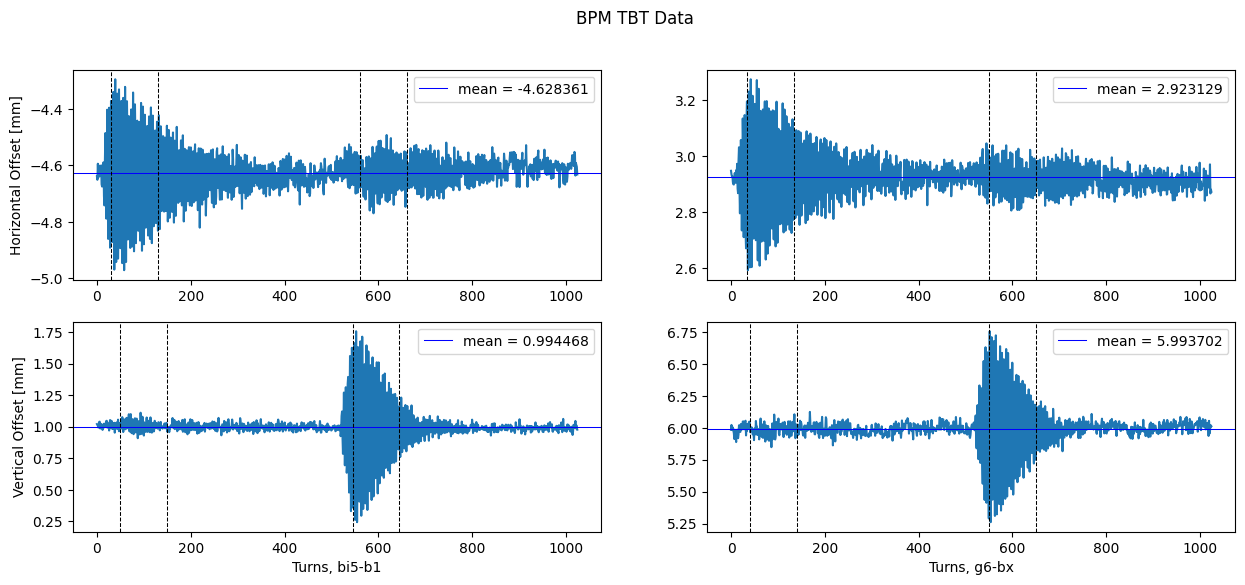

Correlation from first and second bpm: 0.9614333907520443 0.9629218049576209

M:
[[ 0.98547711 16.2614658  -0.02578197 -0.42691752]
 [-0.1073034  -0.81543414 -0.00060345  0.01446671]
 [ 0.01261391  0.54179919  1.08920863 15.72227974]
 [ 0.00166259 -0.01062872 -0.11803483 -0.82042108]]
determinant: 0.9071794384245481
determinant after normalization: 0.9999999999999997
M after normalization:
[[ 1.00977181 16.66235528 -0.02641757 -0.4374422 ]
 [-0.10994872 -0.83553682 -0.00061833  0.01482335]
 [ 0.01292487  0.55515602  1.11606059 16.10987682]
 [ 0.00170358 -0.01089074 -0.12094471 -0.84064669]]
[[ 0.          0.9876411   0.40785034 -0.07008125]
 [-0.9876411   0.         -0.07674445  0.00493343]
 [-0.40785034  0.07674445 -0.          1.00910518]
 [ 0.07008125 -0.00493343 -1.00910518 -0.        ]]
Symplecticity Error: 0.12223147574026871
M not symplectic, no parameterization done

M:
[[-0.77591519 15.71212947  0.04443324 -0.44623627]
 [-0.1062467   0.94573274  0.00126407 -0.03606401]
 [-0.05

In [117]:
interval = 100
print("Bad Horizontal BPMs:", Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx))
print("Bad Vertical BPMs:", Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy))

#downstream of IP6
# Intervals = ([[(30, interval), (560, interval)], [(35, interval), (550, interval)]], 
#              [[(50, interval), (545, interval)], [(40, interval), (550, interval)]])
# Bpms = 163, 165, 162, 164
# b_MADx = [67.80573273, 21.48144505, 1829.361467, 662.1839248]
# b_MADx = [67.80573273, 21.48144505, 662.1839248, 1829.361467]

#at IP6
Intervals = ([[(30, interval), (560, interval)], [(35, interval), (550, interval)]], 
             [[(50, interval), (545, interval)], [(40, interval), (550, interval)]])
Bpms = 167, 0, 166, 0
b_MADx = [100.3380643, 92.50155563, 100.7330716, 92.52663006]

#upstream of IP6
# Intervals = ([[(30, interval), (560, interval)], [(35, interval), (590, interval)]], 
#              [[(50, interval), (545, interval)], [(40, interval), (550, interval)]])
# Bpms = 2, 4, 2, 4
# b_MADx = [667.6941266, 1797.479291, 21.36609832, 66.69759845]

bpm_signals4D(Bpms, Intervals)
Twiss1, Twiss2 = LR_calculation4D(Intervals, Bpms, b_MADx)
Interval_range = np.linspace(5, 200, 196)
# chrom4D(Interval_range, b_MADx)

Bad Horizontal BPMs: [3, 24, 47, 50, 58, 59, 102, 113, 114, 122, 140, 142]
Bad Vertical BPMs: [27, 50, 57, 58, 62, 111, 112, 113, 125, 140]


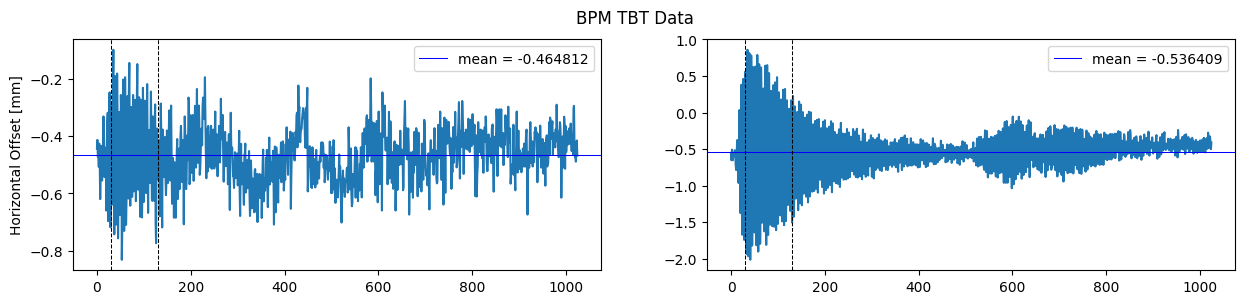

Correlation from bpm 1 & 2: 0.024031434317432654 0.026855989329717722



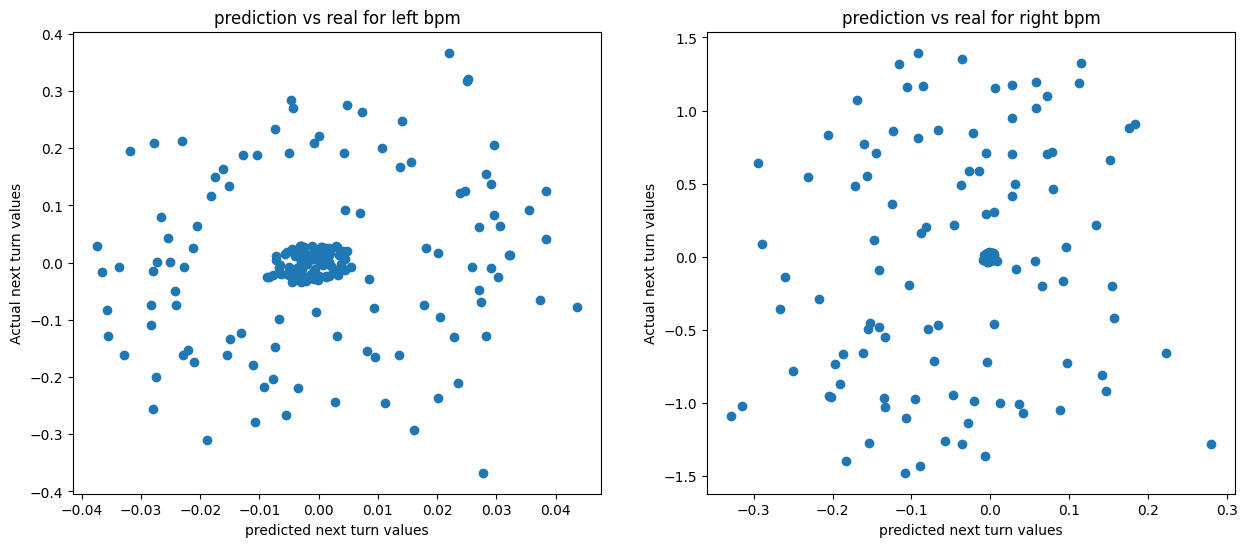


M:
[[ 0.06575173  0.64442755]
 [-0.03355019  0.3603699 ]]
determinant: 0.045315614091785715
determinant after normalization: 1.0000000000000002
M after normalization:
[[ 0.30887537  3.02726307]
 [-0.15760539  1.69287377]]
M:
[[-1.15208938 55.54530784]
 [-0.03355019  1.57821101]]
determinant: 0.04531561409178602
determinant after normalization: 1.0000000000000013
M after normalization:
[[ -5.41205544 260.92965691]
 [ -0.15760539   7.41380458]]
Measured Beta for bpm 1, 2: nan nan

beta beat at bpm 1, 2:
nan nan




/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_3269/461244508.py:15: RuntimeWarning: invalid value encountered in arccos
  phi = np.arccos((M[0, 0] + M[1, 1])/2)


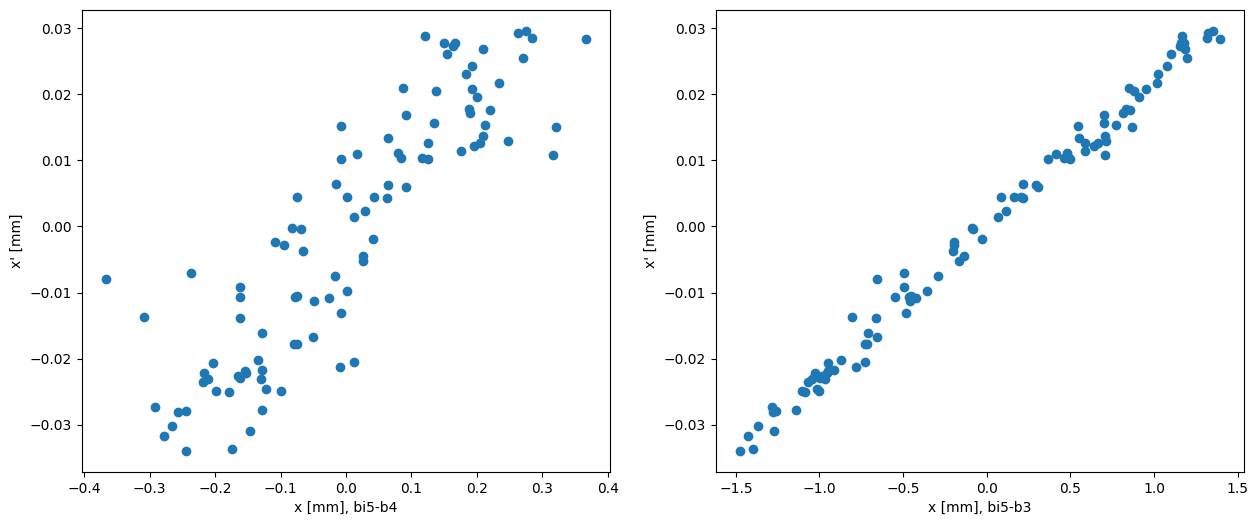

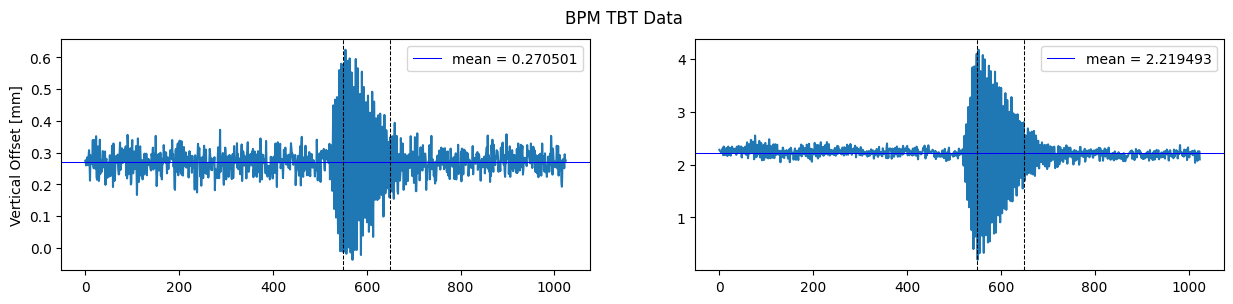

Correlation from bpm 1 & 2: 0.5223981817661516 0.5411270771093922



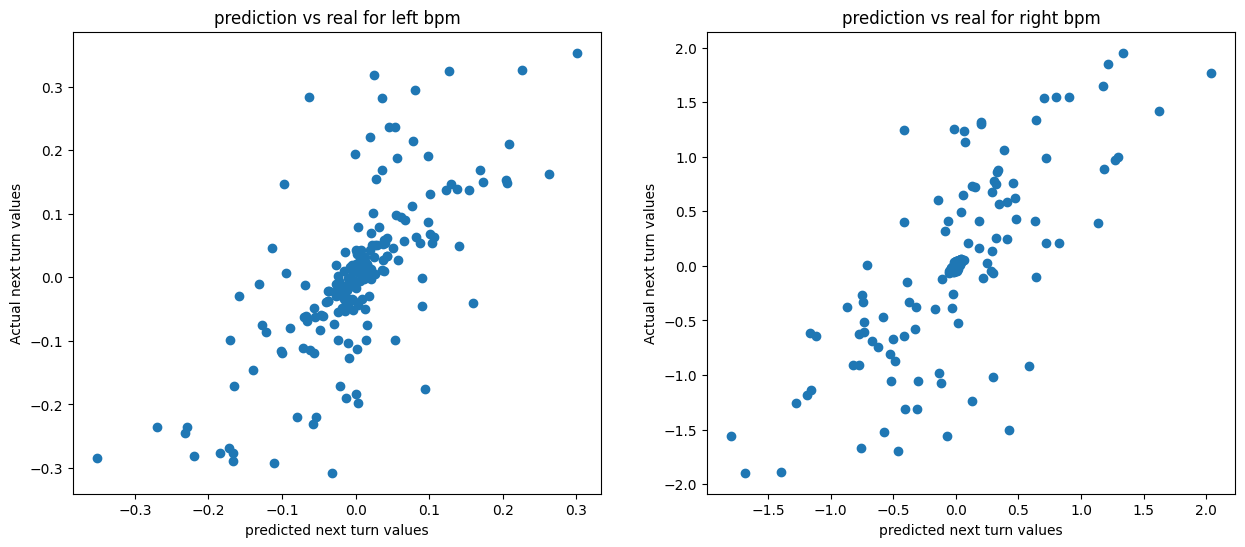


M:
[[ 2.95536134 15.78905006]
 [-0.55430262 -2.78674104]]
determinant: 0.5160850557258138
determinant after normalization: 1.0000000000000024
M after normalization:
[[ 4.11386414 21.97836391]
 [-0.77158946 -3.87914463]]
M:
[[-17.16531372 537.71801006]
 [ -0.55430262  17.33393401]]
determinant: 0.5160850557259343
determinant after normalization: 1.0000000000000058
M after normalization:
[[-23.89412347 748.50368204]
 [ -0.77158946  24.12884298]]
Measured Beta for bpm 1, 2: 22.131303039569115 753.7122362259288

beta beat at bpm 1, 2:
0.9665783142557357 0.5879916299636758




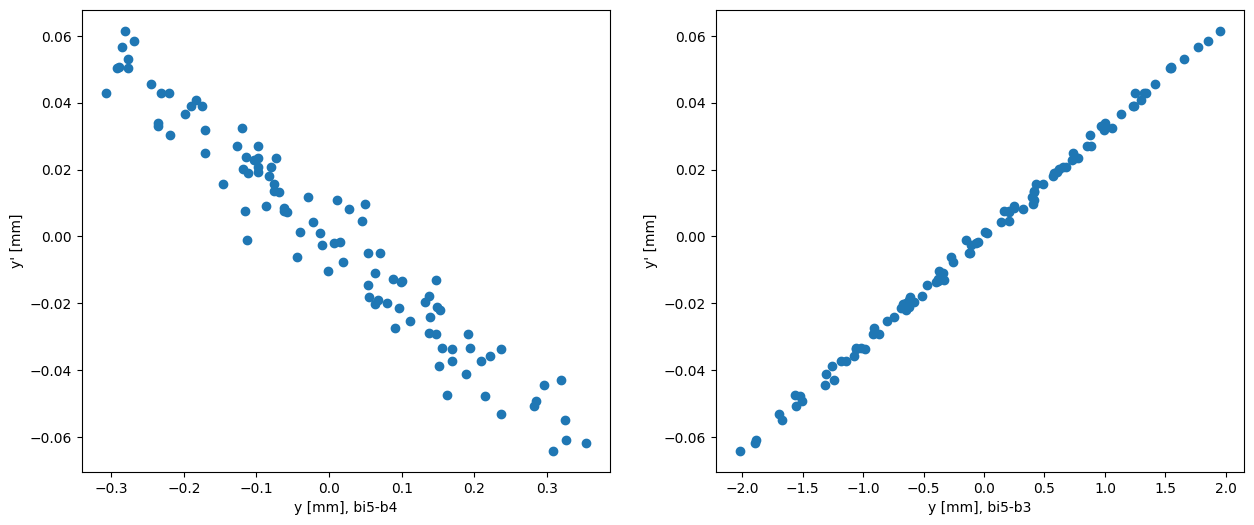

In [22]:
interval = 100
print("Bad Horizontal BPMs:", Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx))
print("Bad Vertical BPMs:", Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy))

#downstream of IP6
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 163, 165
Bpmsy = 162, 164
b_MADxx = [67.80573273, 21.48144505]
b_MADxy = [662.1839248, 1829.361467]

#at IP6
# Intervalsx = (30, interval)
# Intervalsy = (550, interval)
# Bpmsx = 167, 0
# Bpmsy = 166, 0
# b_MADxx = [100.3380643, 100.7330716]
# b_MADxy = [92.50155563, 92.52663006]

#upstream of IP6
# Intervalsx = (30, interval)
# Intervalsy = (550, interval)
# Bpmsx = 2, 4
# b_MADxx = [667.6941266, 21.36609832] 
# Bpmsy = 2, 4
# b_MADxy = [1797.479291, 66.69759845]

Interval_range = np.linspace(5, 200, 196)
# Interval_range = np.linspace(5, 10, 6)
bpm_signals2D(Bpmsx, BPMx, Intervalsx, True)
Twiss1x, Twiss2x = LR_calculation2D(Intervalsx, BPMx, S_xbpms, Bpmsx, b_MADxx, Name_xbpms, True)
# chrom2D(Interval_range, BPMx, S_xbpms, Bpmsx, b_MADxx, True)
# print("-----------------------------------------")
bpm_signals2D(Bpmsy, BPMy, Intervalsy, False)
Twiss1y, Twiss2y = LR_calculation2D(Intervalsy, BPMy, S_ybpms, Bpmsy, b_MADxy, Name_ybpms, False)
# chrom2D(Interval_range, BPMy, S_ybpms, Bpmsy, b_MADxy, False)

### Around IP8

Bad Horizontal BPMs: [3, 24, 47, 50, 58, 59, 102, 113, 114, 122, 140, 142]
Bad Vertical BPMs: [27, 50, 57, 58, 62, 111, 112, 113, 125, 140]


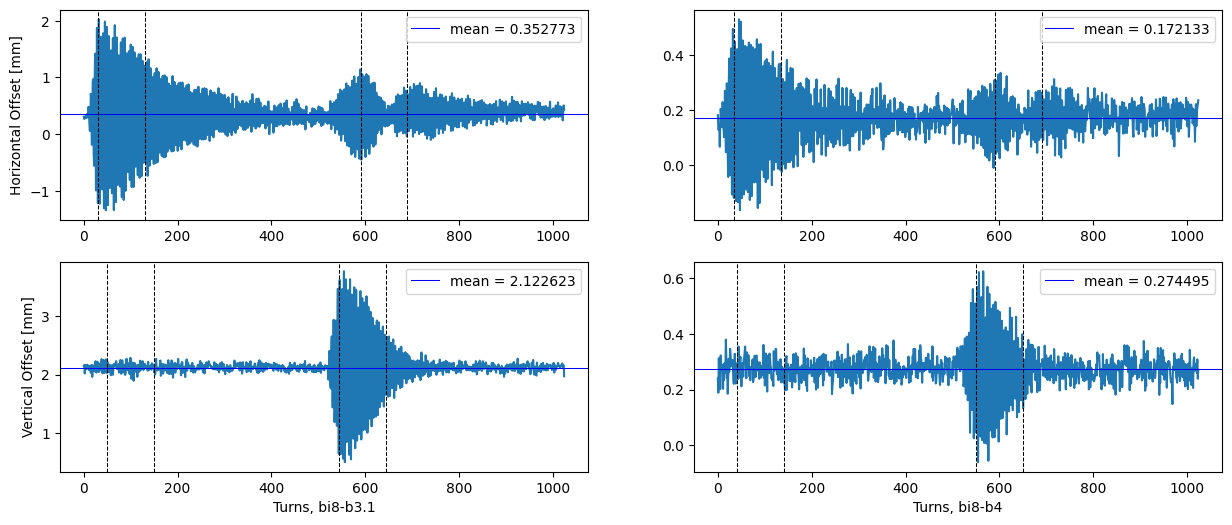

Correlation from first and second bpm: 0.3186325309341989 0.3420346977397722



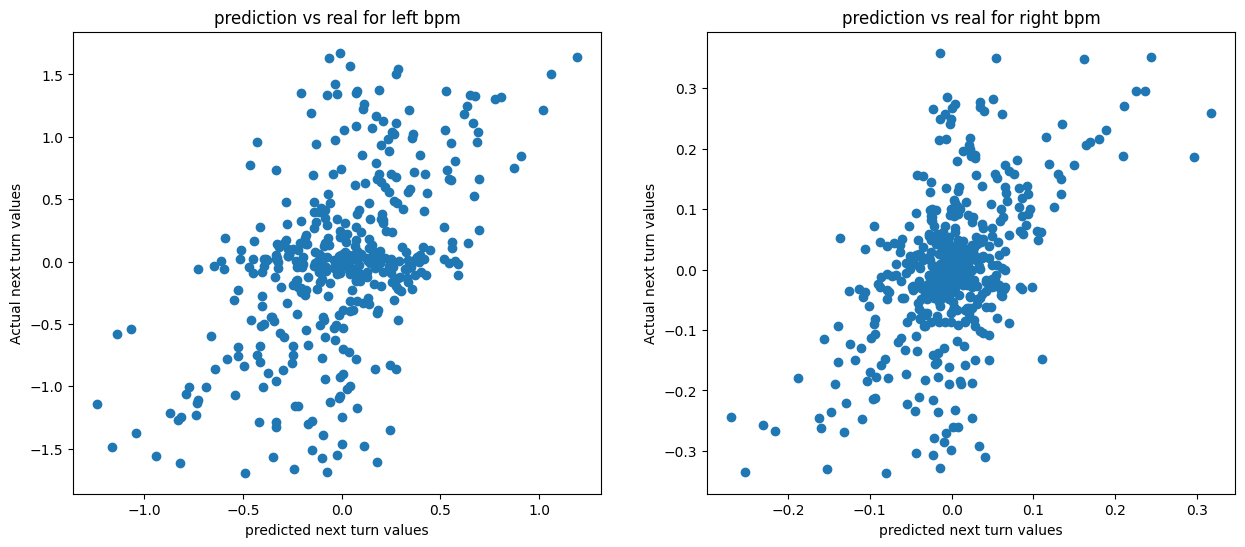


M:
[[  4.06598811 177.77534366  -1.25837159 -32.75460379]
 [ -0.09182242  -4.00196398   0.02861031   0.74580506]
 [ -0.69584281 -30.27355758   9.85591949 299.91500319]
 [  0.02348469   1.01957657  -0.32046176  -9.69841048]]
determinant: 0.02600730469460681
determinant after normalization: 1.000000000000051
M after normalization:
[[ 10.12493557 442.68793961  -3.13353873 -81.56399964]
 [ -0.22865195  -9.96550563   0.07124406   1.85716926]
 [ -1.73275558 -75.38581309  24.54275492 746.83447143]
 [  0.0584805    2.53890243  -0.79799905 -24.15053328]]
Symplecticity:
[[   0.            0.31279858 -334.63599392   10.40624858]
 [  -0.31279858    0.            7.59679749   -0.23629997]
 [ 334.63599392   -7.59679749   -0.            3.26188296]
 [ -10.40624858    0.23629997   -3.26188296    0.        ]]
Symplecticity Error: 85.97645570901022

Stability:
0.2994623091836123
True
0.2521892686896282
True

M after Parameterization:
[[  5.47464039 234.58371393   0.           0.        ]
 [ -0.12267393

In [148]:
interval = 100
print("Bad Horizontal BPMs:", Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx))
print("Bad Vertical BPMs:", Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy))

#downstream of IP8
# Intervals = ([[(30, interval), (560, interval)], [(35, interval), (570, interval)]], 
#              [[(50, interval), (545, interval)], [(40, interval), (550, interval)]])
# Bpms = 23, 25, 24, 26
# b_MADx = [19.87322377, 62.79285429, 661.517763, 1770.202631]

#at IP8
# Intervals = ([[(30, interval), (560, interval)], [(35, interval), (550, interval)]], 
#              [[(50, interval), (545, interval)], [(40, interval), (550, interval)]])
# Bpms = 27, 28, 28, 29
# b_MADx = [99.54348468, 99.62958574, 98.44238123, 98.73952675]

#upstream of IP8
Intervals = ([[(30, interval), (590, interval)], [(35, interval), (590, interval)]], 
             [[(50, interval), (545, interval)], [(40, interval), (550, interval)]])
Bpms = 30, 32, 31, 33
b_MADx = [1814.716854, 649.6131896, 65.47615064, 20.29859581]
b_MADx = [649.6131896, 1814.716854, 20.29859581, 65.47615064]

bpm_signals4D(Bpms, Intervals)
Twiss1, Twiss2 = LR_calculation4D(Intervals, Bpms, b_MADx)

Bad Horizontal BPMs: [3, 24, 47, 50, 58, 59, 102, 113, 114, 122, 140, 142]
Bad Vertical BPMs: [27, 50, 57, 58, 62, 111, 112, 113, 125, 140]


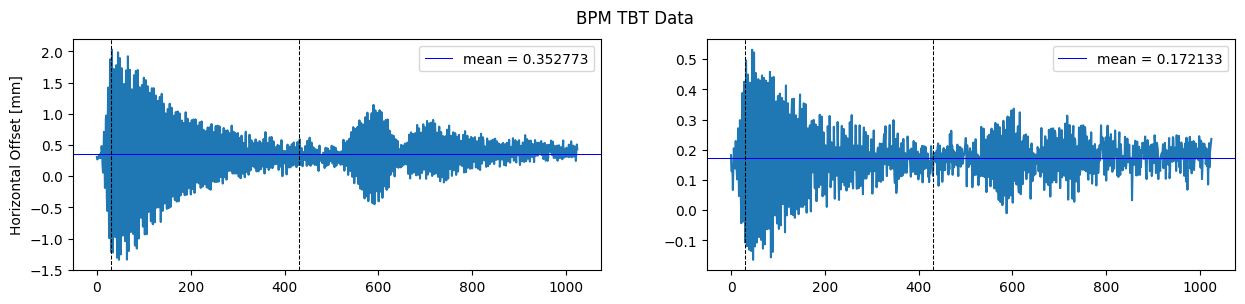

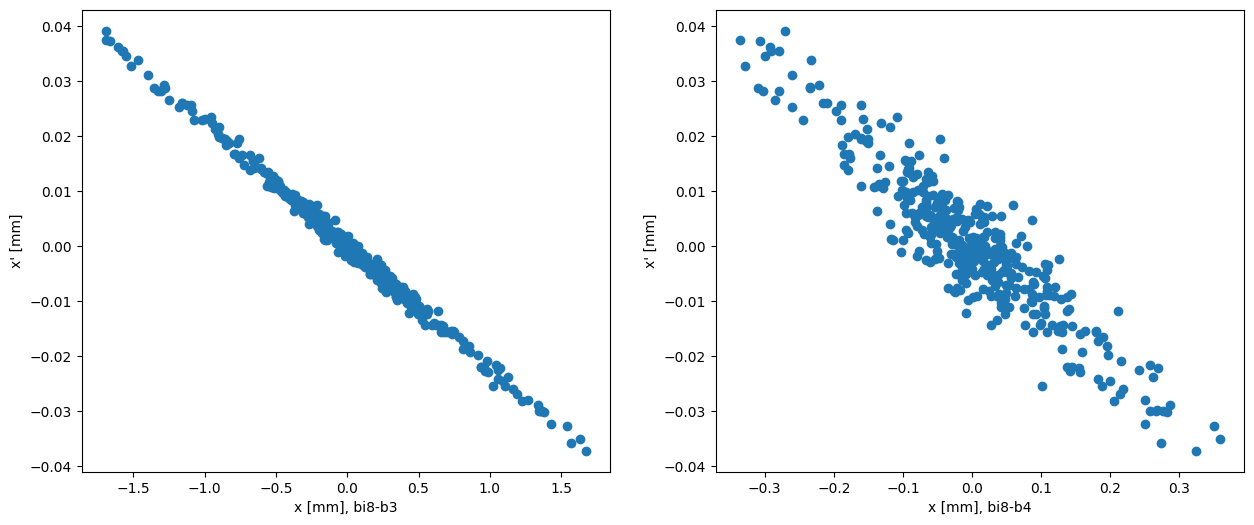

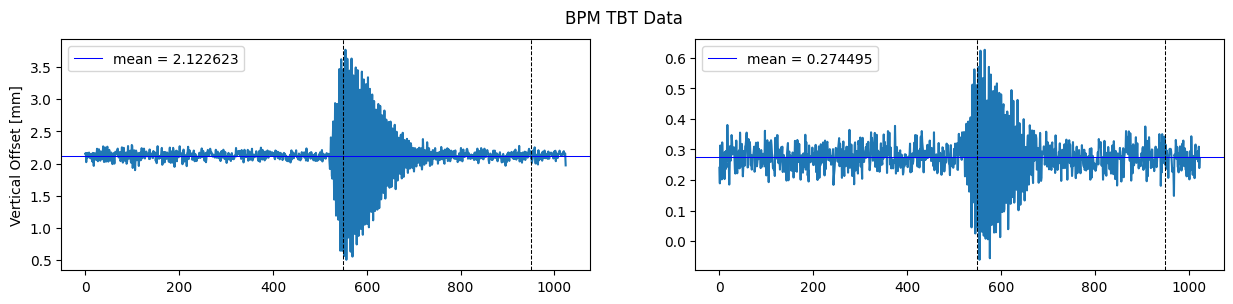

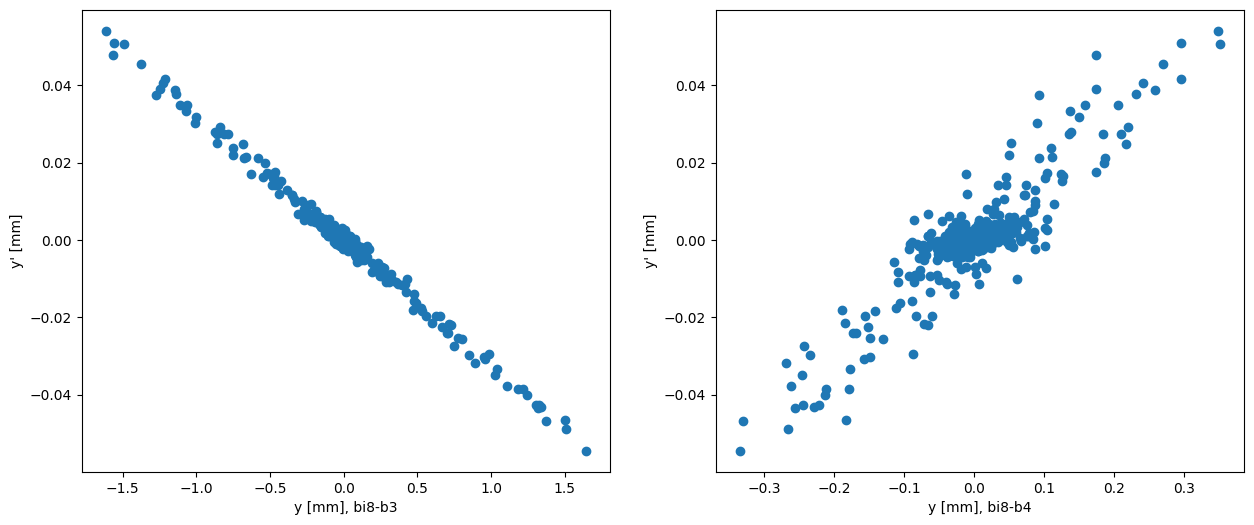

In [67]:
interval = 400
print("Bad Horizontal BPMs:", Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx))
print("Bad Vertical BPMs:", Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy))

#downstream of IP8
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 23, 25
Bpmsy = 24, 26
b_MADxx = [19.87322377, 661.517763]
b_MADxy = [62.79285429, 1770.202631]

#at IP8
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 27, 28
Bpmsy = 28, 29
b_MADxx = [99.54348468, 98.44238123]
b_MADxy = [99.62958574, 98.73952675]

#upstream of IP8
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 30, 32
b_MADxx = [1814.716854, 65.47615064] 
Bpmsy = 31, 33
b_MADxy = [649.6131896, 20.29859581]


bpm_signals2D(Bpmsx, BPMx, Intervalsx, True)
Twiss1x, Twiss2x = LR_calculation2D(Intervalsx, BPMx, S_xbpms, Bpmsx, b_MADxx, Name_xbpms, True)
# chrom2D(Interval_range, BPMx, S_xbpms, Bpmsx, b_MADxx, True)
# print("-----------------------------------------")
bpm_signals2D(Bpmsy, BPMy, Intervalsy, False)
Twiss1y, Twiss2y = LR_calculation2D(Intervalsy, BPMy, S_ybpms, Bpmsy, b_MADxy, Name_ybpms, False)
# chrom2D(Interval_range, BPMy, S_ybpms, Bpmsy, b_MADxy, False)

### Around IP10

Bad Horizontal BPMs: [3, 24, 47, 50, 58, 59, 102, 113, 114, 122, 140, 142]
Bad Vertical BPMs: [27, 50, 57, 58, 62, 111, 112, 113, 125, 140]


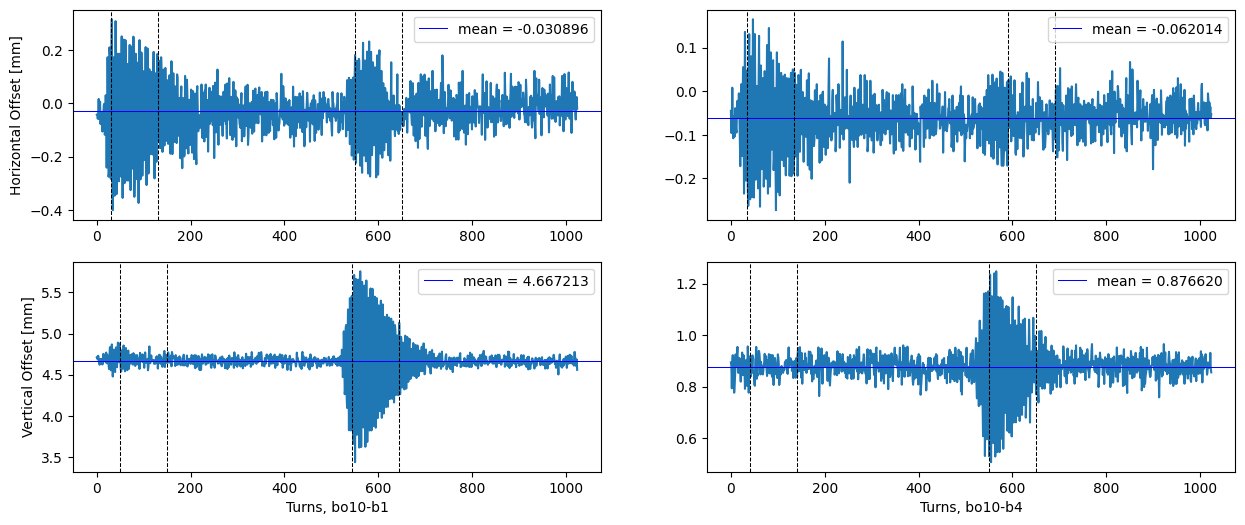

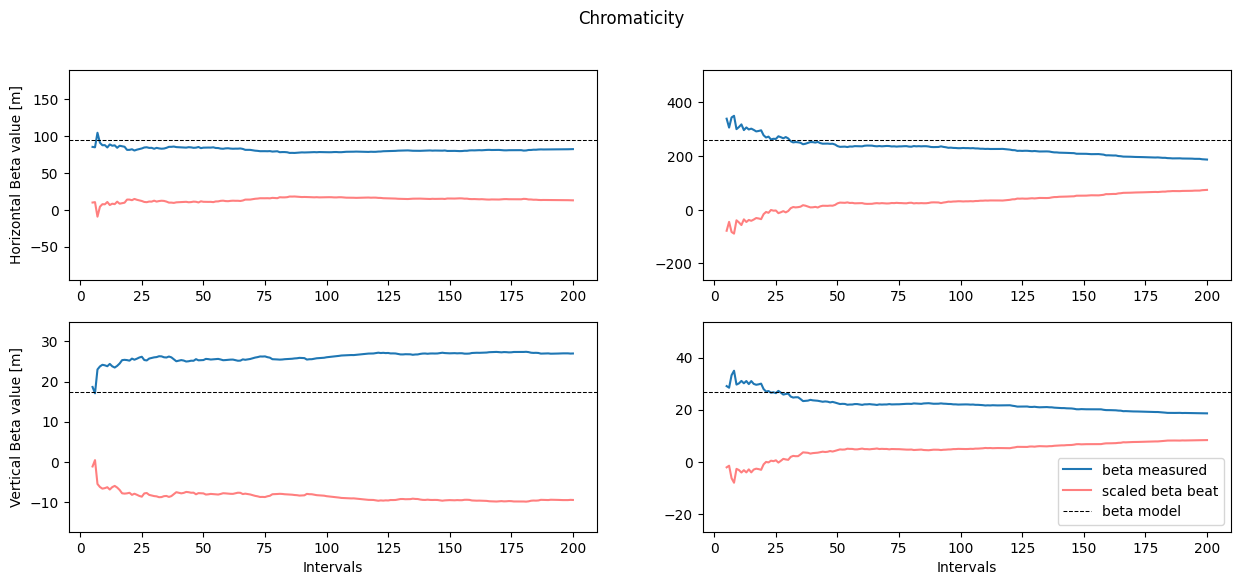

In [91]:
interval = 100
print("Bad Horizontal BPMs:", Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx))
print("Bad Vertical BPMs:", Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy))

#downstream of IP10
# Intervals = ([[(30, interval), (560, interval)], [(35, interval), (570, interval)]], 
#              [[(50, interval), (545, interval)], [(40, interval), (550, interval)]])
# Bpms = 53, 55, 53, 54
# b_MADx = [25.55882593, 21.81527574, 259.1350568, 92.99599271]
# b_MADx = [21.81527574, 25.55882593, 259.1350568, 92.99599271]

#at IP10
# Intervals = ([[(30, interval), (560, interval)], [(35, interval), (550, interval)]], 
#              [[(50, interval), (545, interval)], [(40, interval), (550, interval)]])
# Bpms = 57, 60, 56, 59
# b_MADx = [18.85271553, 18.67088168, 18.70458023, 19.05146489]

#upstream of IP10
Intervals = ([[(30, interval), (550, interval)], [(35, interval), (590, interval)]], 
             [[(50, interval), (545, interval)], [(40, interval), (550, interval)]])
Bpms = 62, 64, 61, 63
b_MADx = [94.60224219, 260.6868242, 17.45850739, 26.88939256]

bpm_signals4D(Bpms, Intervals)
# Twiss1, Twiss2 = LR_calculation4D(Intervals, Bpms, b_MADx)
Interval_range = np.linspace(5, 200, 196)
chrom4D(Interval_range, b_MADx)

Bad Horizontal BPMs: [3, 24, 47, 50, 58, 59, 102, 113, 114, 122, 140, 142]
Bad Vertical BPMs: [27, 50, 57, 58, 62, 111, 112, 113, 125, 140]


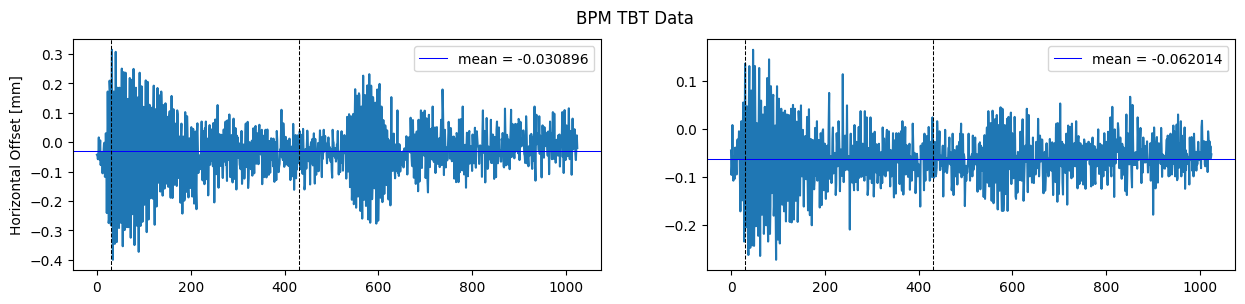

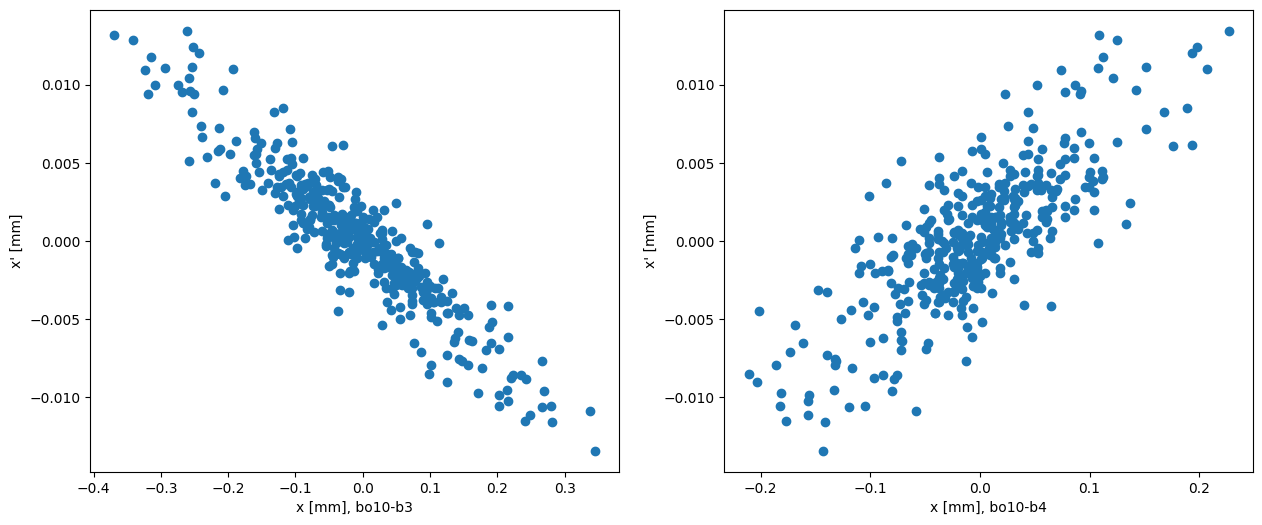

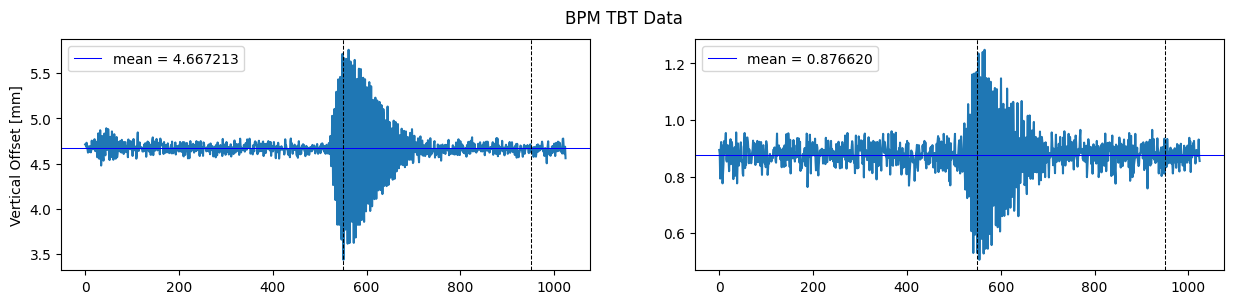

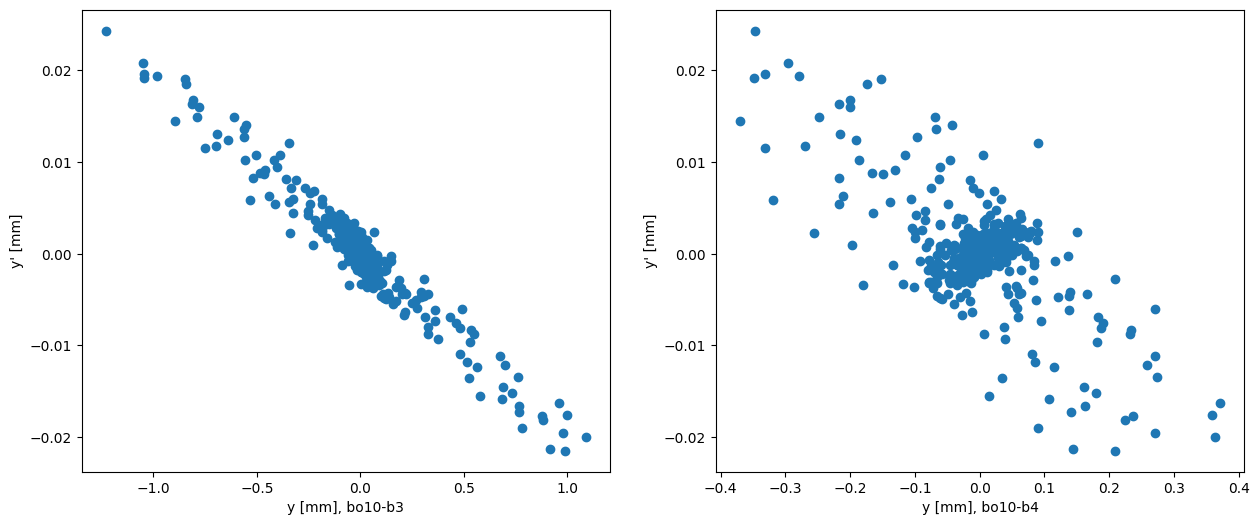

In [71]:
interval = 400
print("Bad Horizontal BPMs:", Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx))
print("Bad Vertical BPMs:", Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy))

#downstream of IP10
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 53, 55
Bpmsy = 53, 54
b_MADxx = [21.81527574, 259.1350568]
b_MADxy = [25.55882593, 92.99599271]

#at IP8
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 57, 60
Bpmsy = 56, 59
b_MADxx = [18.85271553, 18.70458023]
b_MADxy = [18.67088168, 19.05146489]

#upstream of IP10
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 62, 64
b_MADxx = [94.60224219, 17.45850739] 
Bpmsy = 61, 63
b_MADxy = [260.6868242, 26.88939256]

Interval_range = np.linspace(5, 200, 196)
bpm_signals2D(Bpmsx, BPMx, Intervalsx, True)
Twiss1x, Twiss2x = LR_calculation2D(Intervalsx, BPMx, S_xbpms, Bpmsx, b_MADxx, Name_xbpms, True)
# chrom2D(Interval_range, BPMx, S_xbpms, Bpmsx, b_MADxx, True)
# print("-----------------------------------------")
bpm_signals2D(Bpmsy, BPMy, Intervalsy, False)
Twiss1y, Twiss2y = LR_calculation2D(Intervalsy, BPMy, S_ybpms, Bpmsy, b_MADxy, Name_ybpms, False)
# chrom2D(Interval_range, BPMy, S_ybpms, Bpmsy, b_MADxy, False)

### Around IP12 

Bad Horizontal BPMs: [3, 24, 47, 50, 58, 59, 102, 113, 114, 122, 140, 142]
Bad Vertical BPMs: [27, 50, 57, 58, 62, 111, 112, 113, 125, 140]


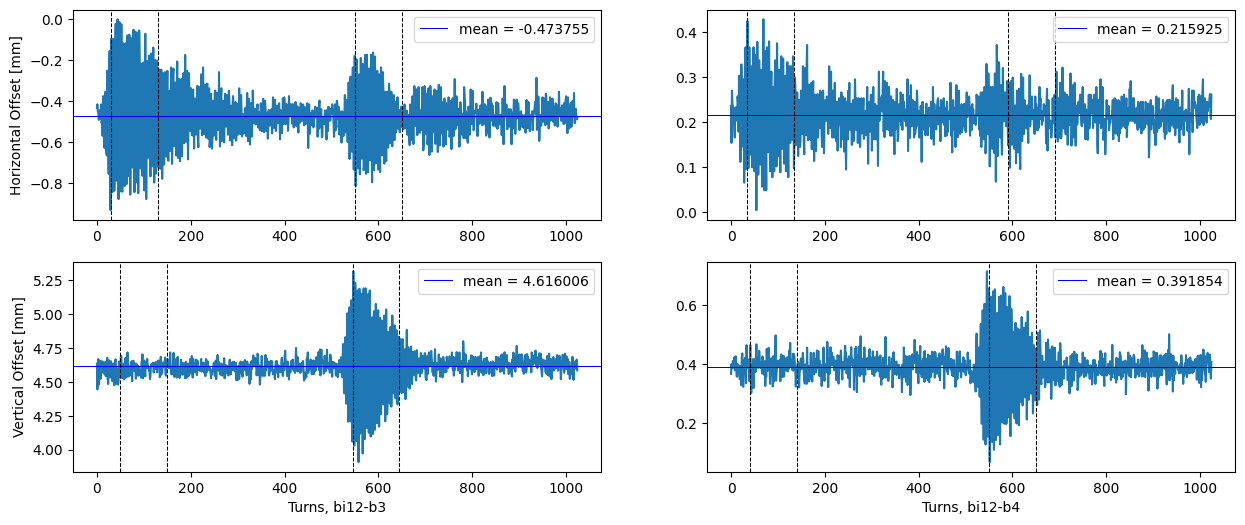

Correlation from first and second bpm: 0.7447160371458041 0.680694297666216



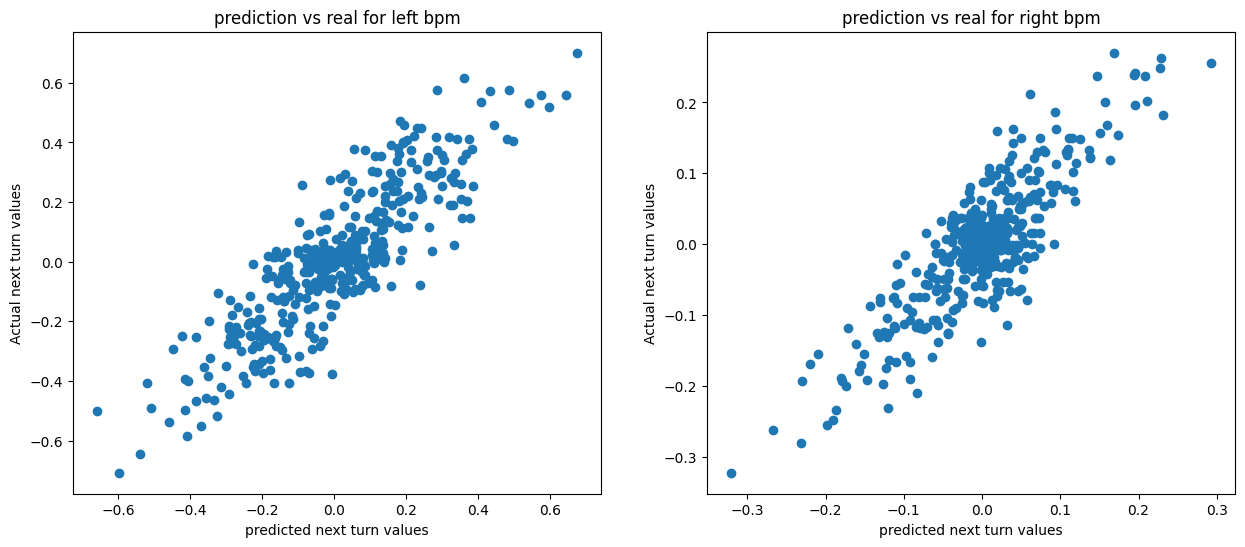


M:
[[  2.06598064  98.85822809  -0.84793865 -26.17931367]
 [ -0.04538002  -1.92208811   0.01666947   0.53789468]
 [ -0.02139682   1.99009464   2.99283526  85.51606355]
 [  0.00253695  -0.01318963  -0.10623565  -2.76729689]]
determinant: 0.4215242321746127
determinant after normalization: 0.9999999999999987
M after normalization:
[[  2.56401529 122.68944037  -1.05234658 -32.49021761]
 [ -0.05631954  -2.38543537   0.02068789   0.66756201]
 [ -0.02655484   2.46983587   3.71430168 106.13095322]
 [  0.00314852  -0.01636918  -0.1318453   -3.43439401]]
Symplecticity:
[[ -0.           0.7631671   18.58261986  -1.09777069]
 [ -0.7631671    0.          -0.48634656   0.02539706]
 [-18.58261986   0.48634656   0.           1.22915007]
 [  1.09777069  -0.02539706  -1.22915007  -0.        ]]
Symplecticity Error: 4.858772614204599
M not symplectic, no parameterization done

M:
[[ 0.39347991 13.04358898 -0.03165124 -0.26557866]
 [-0.04565387 -0.25413503  0.00489413  0.0061607 ]
 [ 0.03899931  0.705899

In [21]:
interval = 100
print("Bad Horizontal BPMs:", Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx))
print("Bad Vertical BPMs:", Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy))

#downstream of IP12
Intervals = ([[(30, interval), (560, interval)], [(35, interval), (570, interval)]], 
             [[(50, interval), (545, interval)], [(40, interval), (550, interval)]])
Bpms = 83, 84, 83, 84
b_MADx = [20.60080992, 26.4804521, 94.79244064, 261.2369843]

#at IP12
# Intervals = ([[(30, interval), (560, interval)], [(35, interval), (550, interval)]], 
#              [[(50, interval), (545, interval)], [(40, interval), (550, interval)]])
# Bpms = 86, 87, 86, 87
# b_MADx = [19.15235045, 18.63167495, 18.8909464, 18.91331833]

#upstream of IP12
Intervals = ([[(30, interval), (550, interval)], [(35, interval), (590, interval)]], 
             [[(50, interval), (545, interval)], [(40, interval), (550, interval)]])
Bpms = 89, 90, 89, 90
#b_MADx = [259.7640288, 94.20459319, 26.73997493, 21.34783386]
b_MADx = [259.7640288, 94.20459319, 21.34783386, 26.73997493]

bpm_signals4D(Bpms, Intervals)
Twiss1, Twiss2 = LR_calculation4D(Intervals, Bpms, b_MADx)

Bad Horizontal BPMs: [3, 24, 47, 50, 58, 59, 102, 113, 114, 122, 140, 142]
Bad Vertical BPMs: [27, 50, 57, 58, 62, 111, 112, 113, 125, 140]


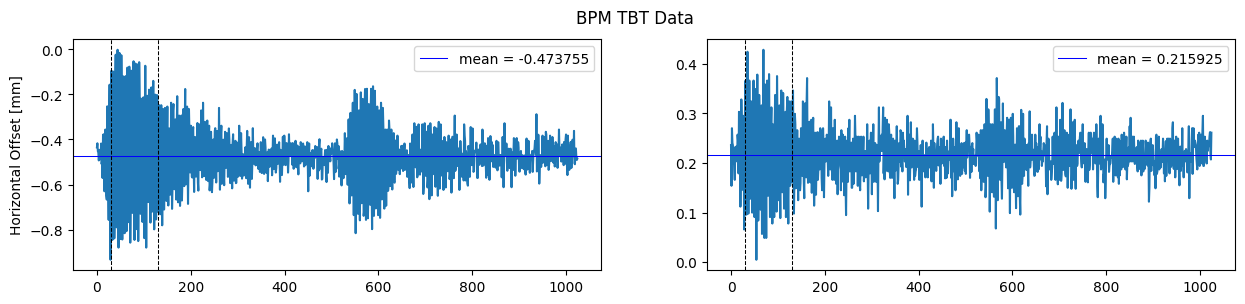

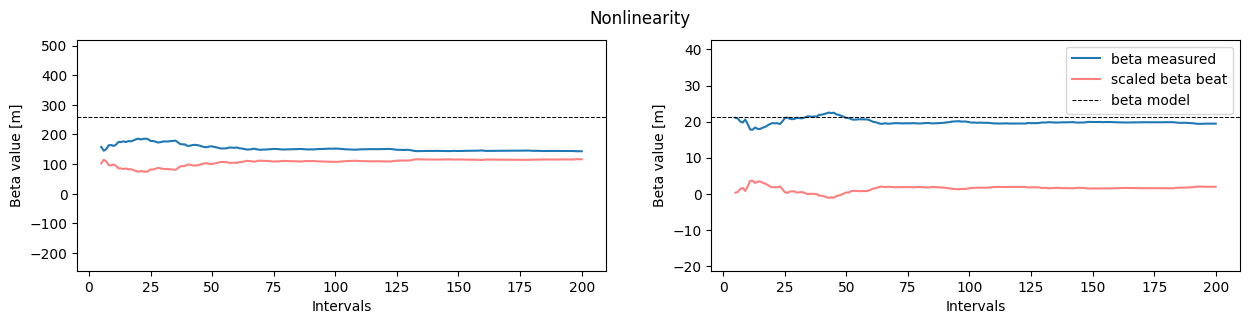

-----------------------------------------


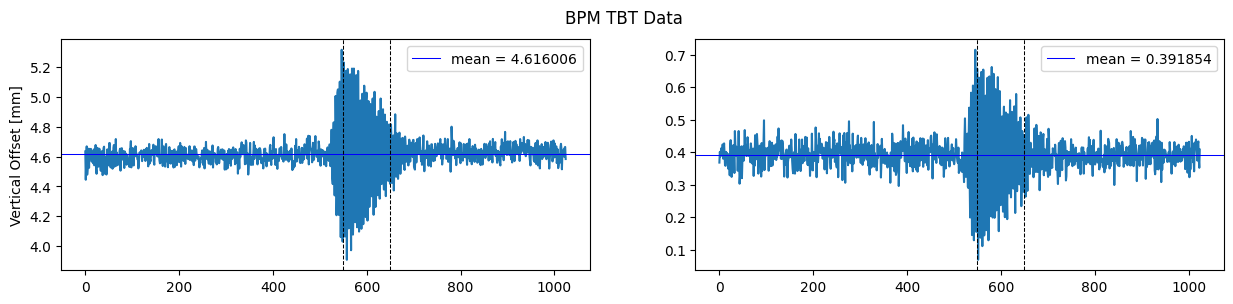

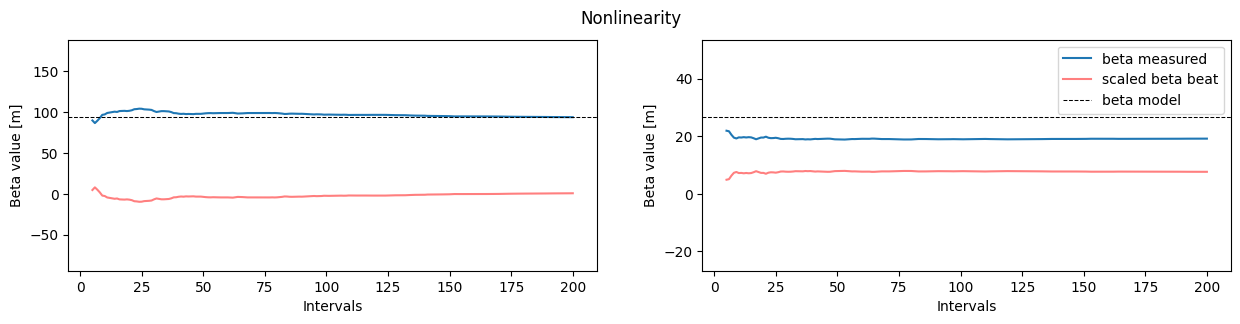

In [74]:
interval = 100
print("Bad Horizontal BPMs:", Bad_Bpms(BPMx_Tune_Map, nu_x, N_BPMx))
print("Bad Vertical BPMs:", Bad_Bpms(BPMy_Tune_Map, nu_y, N_BPMy))

#downstream of IP12
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 83, 84
Bpmsy = 83, 84
b_MADxx = [20.60080992, 94.79244064]
b_MADxy = [26.4804521, 261.2369843]

#at IP12
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 86, 87
Bpmsy = 86, 87
b_MADxx = [19.15235045, 18.8909464]
b_MADxy = [18.63167495, 18.91331833]

#upstream of IP12
Intervalsx = (30, interval)
Intervalsy = (550, interval)
Bpmsx = 89, 90
b_MADxx = [259.7640288, 21.34783386] 
Bpmsy = 89, 90
b_MADxy = [94.20459319, 26.73997493]

Interval_range = np.linspace(5, 200, 196)
bpm_signals2D(Bpmsx, BPMx, Intervalsx, True)
# Twiss1x, Twiss2x = LR_calculation2D(Intervalsx, BPMx, S_xbpms, Bpmsx, b_MADxx)
chrom2D(Interval_range, BPMx, S_xbpms, Bpmsx, b_MADxx, True)
print("-----------------------------------------")
bpm_signals2D(Bpmsy, BPMy, Intervalsy, False)
# Twiss1y, Twiss2y = LR_calculation2D(Intervalsy, BPMy, S_ybpms, Bpmsy, b_MADxy)
chrom2D(Interval_range, BPMy, S_ybpms, Bpmsy, b_MADxy, False)

## Excel stuff

In [102]:
with open('BPM LR Direct Measurement - 2D.csv') as datafile:
    datareader = csv.reader(datafile, delimiter=';')
    data = []
    for row in datareader:
        data_row = []
        Row = list(row[0].split(","))
        for col in Row:
            data_row.append(col)  
        data.append(np.array(data_row))
    data = np.array(data)
Regions = data.T[0, 2:14]

Corr_x_1 = (data.T[1, 2:14]).astype(float)
Corr_x_2 = (data.T[2, 2:14]).astype(float)
Corr_y_1 = (data.T[3, 2:14]).astype(float)
Corr_y_2 = (data.T[4, 2:14]).astype(float)

Det_x_1 = (data.T[5, 2:14]).astype(float)
Det_x_2 = (data.T[6, 2:14]).astype(float)
Det_y_1 = (data.T[7, 2:14]).astype(float)
Det_y_2 = (data.T[8, 2:14]).astype(float)

Tune_x_1 = (data.T[9, 2:14]).astype(float)
Tune_x_2 = (data.T[10, 2:14]).astype(float)
Tune_y_1 = (data.T[11, 3:14]).astype(float)
Tune_y_2 = (data.T[12, 3:14]).astype(float)

Beat_x_1 = (data.T[13, 3:14]).astype(float)
Beat_y_1 = (data.T[14, 2:14]).astype(float)
Beat_x_2 = (data.T[15, 3:14]).astype(float)
Beat_y_2 = (data.T[16, 2:14]).astype(float)


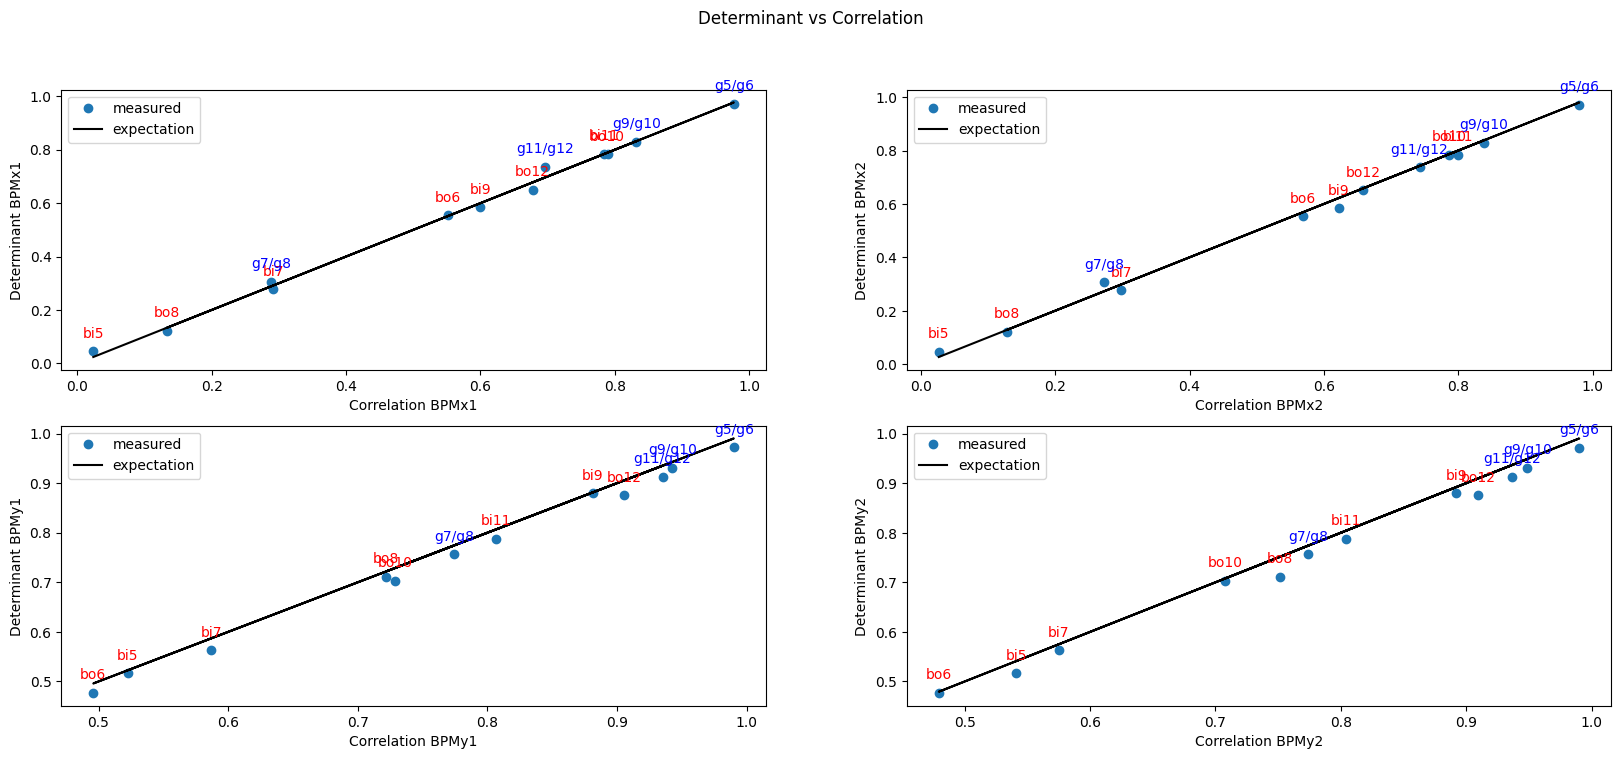

In [103]:
fig, Ax = plt.subplots(2, 2, figsize=(20, 8))
fig.suptitle("Determinant vs Correlation")
Ax[0][0].plot(Corr_x_1, Det_x_1, 'o', label = "measured")
Ax[0][0].plot(Corr_x_1, Corr_x_1, 'k', label = "expectation")
Ax[0][0].set_xlabel("Correlation BPMx1")
Ax[0][0].set_ylabel("Determinant BPMx1")


Ax[0][1].plot(Corr_x_2, Det_x_2, 'o', label = "measured")
Ax[0][1].plot(Corr_x_2, Corr_x_2, 'k', label = "expectation")
Ax[0][1].set_xlabel("Correlation BPMx2")
Ax[0][1].set_ylabel("Determinant BPMx2")

Ax[1][0].plot(Corr_y_1, Det_y_1, 'o', label = "measured")
Ax[1][0].plot(Corr_y_1, Corr_y_1, 'k', label = "expectation")
Ax[1][0].set_xlabel("Correlation BPMy1")
Ax[1][0].set_ylabel("Determinant BPMy1")

Ax[1][1].plot(Corr_y_2, Det_y_2, 'o', label = "measured")
Ax[1][1].plot(Corr_y_2, Corr_y_2, 'k', label = "expectation")
Ax[1][1].set_xlabel("Correlation BPMy2")
Ax[1][1].set_ylabel("Determinant BPMy2")
for i in range(2):
    for j in range(2):
        iter = 0
        for x, y, text in zip(data.T[1 + i*2 + j, 2:14], data.T[5 + i*2 + j, 2:14], Regions):
#             print(text, iter)
            if 'b' in text:
                if iter < 7: text = text[:3]
                elif iter >= 7: text = text[:4]
            if iter % 3 - 1 == 0: color = 'b'
            else: color = 'r'
            Ax[i][j].annotate(text, # this is the text
                (float(x),float(y)), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center',
                color = color) # horizontal alignment can be left, right or center
            iter += 1
        Ax[i][j].legend()
plt.show()

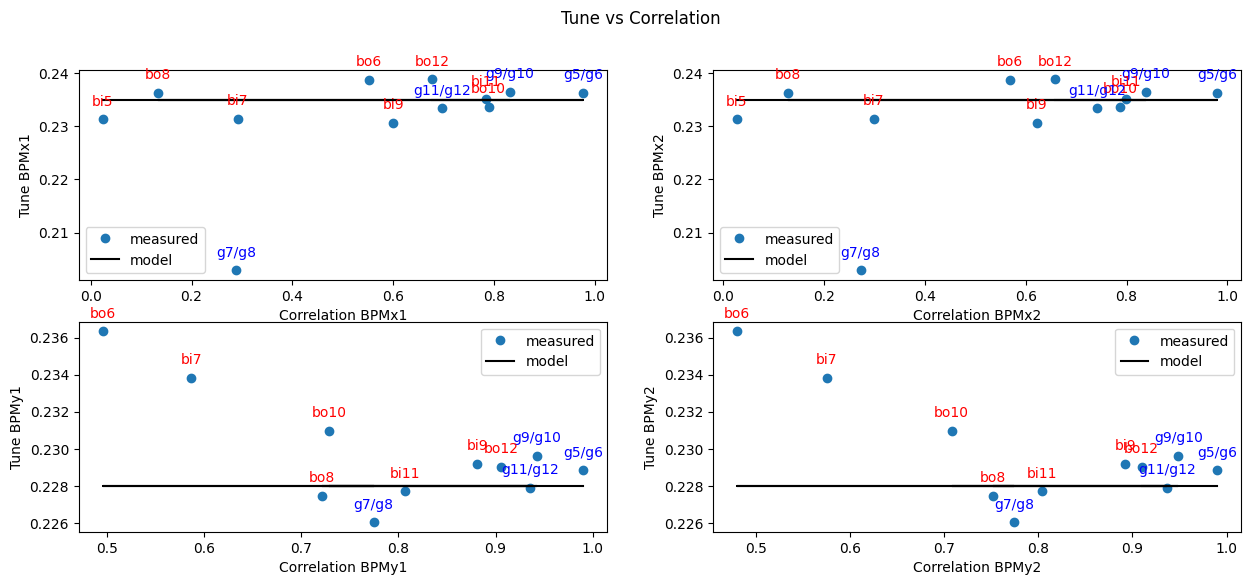

In [107]:
fig, Ax = plt.subplots(2, 2, figsize=(15, 6))
fig.suptitle("Tune vs Correlation")
Ax[0][0].plot(Corr_x_1, Tune_x_1, 'o', label = "measured")
Ax[0][0].plot(Corr_x_1, np.ones(12)*nu_x, 'k', label = "model")
Ax[0][0].set_xlabel("Correlation BPMx1")
Ax[0][0].set_ylabel("Tune BPMx1")

Ax[0][1].plot(Corr_x_2, Tune_x_2, 'o', label = "measured")
Ax[0][1].plot(Corr_x_2, np.ones(12)*nu_x, 'k', label = "model")
Ax[0][1].set_xlabel("Correlation BPMx2")
Ax[0][1].set_ylabel("Tune BPMx2")

Ax[1][0].plot(Corr_y_1[1:], Tune_y_1, 'o', label = "measured")
Ax[1][0].plot(Corr_y_1[1:], np.ones(11)*nu_y, 'k', label = "model")
Ax[1][0].set_xlabel("Correlation BPMy1")
Ax[1][0].set_ylabel("Tune BPMy1")

Ax[1][1].plot(Corr_y_2[1:], Tune_y_2, 'o', label = "measured")
Ax[1][1].plot(Corr_y_2[1:], np.ones(11)*nu_y, 'k', label = "model")
Ax[1][1].set_xlabel("Correlation BPMy2")
Ax[1][1].set_ylabel("Tune BPMy2")

for i in range(2):
    for j in range(2):
        iter = 0
        if i == 1:
            X = data.T[1 + i*2 + j, 3:14]
            Y = data.T[9 + i*2 + j, 3:14]
            Regions = data.T[0, 3:14]
        else: 
            X = data.T[1 + i*2 + j, 2:14]
            Y = data.T[9 + i*2 + j, 2:14]
            Regions = data.T[0, 2:14]
        for x, y, text in zip(X, Y, Regions):
            if 'b' in text:
                if iter < 7: text = text[:3]
                elif iter >= 7: text = text[:4]
            if i == 1:
                if iter % 3 == 0: color = 'b'
                else: color = 'r'
            else:
                if iter % 3 - 1 == 0: color = 'b'
                else: color = 'r'
            Ax[i][j].annotate(text, # this is the text
                (float(x),float(y)), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center',
                color = color) # horizontal alignment can be left, right or center
            iter += 1
        Ax[i][j].legend()
plt.show()

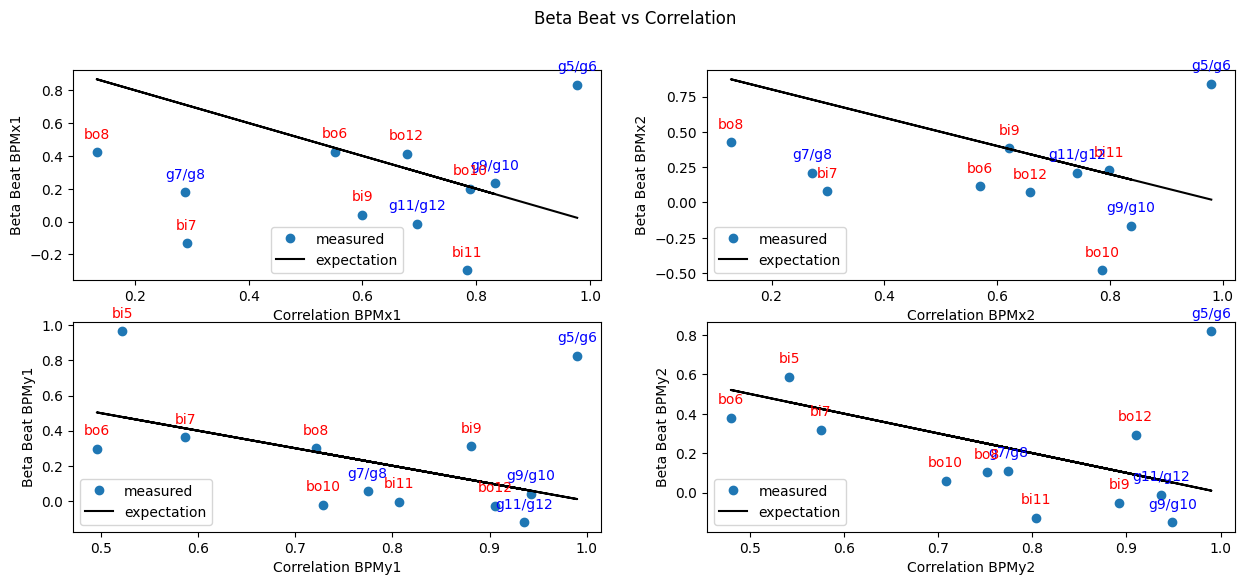

In [109]:
Regions = data.T[0, 2:14]
fig, Ax = plt.subplots(2, 2, figsize=(15, 6))
fig.suptitle("Beta Beat vs Correlation")
Ax[0][0].plot(Corr_x_1[1:], Beat_x_1, 'o', label = "measured")
Ax[0][0].plot(Corr_x_1[1:], 1 - Corr_x_1[1:], 'k', label = "expectation")
iter = 0
for x, y, text in zip(Corr_x_1[1:], Beat_x_1, Regions[1:]):
    if 'b' in text:
        if iter < 7: text = text[:3]
        elif iter >= 7: text = text[:4]
    if iter % 3 == 0: color = 'b'
    else: color = 'r'
    Ax[0][0].annotate(text, # this is the text
        (float(x),float(y)), # these are the coordinates to position the label
        textcoords="offset points", # how to position the text
        xytext=(0,10), # distance from text to points (x,y)
        ha='center',
        color = color)
    iter += 1
Ax[0][0].set_xlabel("Correlation BPMx1")
Ax[0][0].set_ylabel("Beta Beat BPMx1")

Ax[0][1].plot(Corr_x_2[1:], Beat_x_2, 'o', label = "measured")
Ax[0][1].plot(Corr_x_2[1:], 1 - Corr_x_2[1:], 'k', label = "expectation")
iter = 0
for x, y, text in zip(Corr_x_2[1:], Beat_x_2, Regions[1:]):
    if 'b' in text:
        if iter < 7: text = text[:3]
        elif iter >= 7: text = text[:4]
    if iter % 3 == 0: color = 'b'
    else: color = 'r'
    Ax[0][1].annotate(text, # this is the text
        (float(x),float(y)), # these are the coordinates to position the label
        textcoords="offset points", # how to position the text
        xytext=(0,10), # distance from text to points (x,y)
        ha='center',
        color = color)
    iter += 1
Ax[0][1].set_xlabel("Correlation BPMx2")
Ax[0][1].set_ylabel("Beta Beat BPMx2")

Ax[1][0].plot(Corr_y_1, Beat_y_1, 'o', label = "measured")
Ax[1][0].plot(Corr_y_1, 1 - Corr_y_1, 'k', label = "expectation")
iter = 0
for x, y, text in zip(Corr_y_1, Beat_y_1, Regions):
    if 'b' in text:
        if iter < 7: text = text[:3]
        elif iter >= 7: text = text[:4]
    if iter % 3 - 1 == 0: color = 'b'
    else: color = 'r'
    Ax[1][0].annotate(text, # this is the text
        (float(x),float(y)), # these are the coordinates to position the label
        textcoords="offset points", # how to position the text
        xytext=(0,10), # distance from text to points (x,y)
        ha='center',
        color = color)
    iter += 1
Ax[1][0].set_xlabel("Correlation BPMy1")
Ax[1][0].set_ylabel("Beta Beat BPMy1")

Ax[1][1].plot(Corr_y_2, Beat_y_2, 'o', label = "measured")
Ax[1][1].plot(Corr_y_2, 1 - Corr_y_2, 'k', label = "expectation")
iter = 0
for x, y, text in zip(Corr_y_2, Beat_y_2, Regions):
    if 'b' in text:
        if iter < 7: text = text[:3]
        elif iter >= 7: text = text[:4]
    if iter % 3 - 1 == 0: color = 'b'
    else: color = 'r'
    Ax[1][1].annotate(text, # this is the text
        (float(x),float(y)), # these are the coordinates to position the label
        textcoords="offset points", # how to position the text
        xytext=(0,10), # distance from text to points (x,y)
        ha='center',
        color = color)
    iter += 1
Ax[1][1].set_xlabel("Correlation BPMy2")
Ax[1][1].set_ylabel("Beta Beat BPMy2")
for i in range(2):
    for j in range(2):
        Ax[i][j].legend()
plt.show()